In [3]:
!git clone https://github.com/minimario/gtsrb

fatal: destination path 'gtsrb' already exists and is not an empty directory.


In [4]:
import tensorflow as tf
from skimage import io
import os
import glob
from keras.models import load_model
import numpy as np
from skimage import color, exposure, transform
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import keras
import cv2
from tensorflow.keras.activations import relu,softplus

NUM_CLASSES = 43
IMG_SIZE = 48

def preprocess_img(img):
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # central square crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img, -1)

    return img


def get_class(img_path):
    return int(img_path.split('/')[-2])


root_dir = 'gtsrb/GTSRB/Final_Training/Images/'
imgs = []
labels = []

all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
np.random.seed(1234)
np.random.shuffle(all_img_paths)
for i in range(500): # len(all_img_paths)
  img_path = all_img_paths[i]
  img = preprocess_img(io.imread(img_path))
  label = get_class(img_path)
  imgs.append(img)
  labels.append(label)

X = np.array(imgs, dtype='float32')
Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]
print(X.shape, Y.shape)

(500, 3, 48, 48) (500, 43)


In [5]:
X = X.transpose(0, 2, 3, 1)
X.shape

(500, 48, 48, 3)

In [6]:
model = load_model('gtsrb/model_small_92.h5')
model_sp = load_model('gtsrb/model_small_92.h5')
fc_weights = np.asarray(model.weights[-2].numpy())

for layer in model_sp.layers:
  if hasattr(layer, 'activation') and layer.activation == relu:
    layer.activation = softplus

model_sp.compile()
last_conv_layer_output_model = keras.Model(model_sp.input, model_sp.get_layer(index = -3).output) 

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 8)         224       
_________________________________________________________________
activation_8 (Activation)    (None, 48, 48, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 8)         584       
_________________________________________________________________
activation_9 (Activation)    (None, 48, 48, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 8)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 16)       

In [7]:
channels = 16

def get_maximum_indices(array, num_indices):
  flat_indices = np.argpartition(-array.ravel(), num_indices-1)[:num_indices]
  row_indices, col_indices = np.unravel_index(flat_indices, array.shape)
  return row_indices, col_indices

def get_maximum_indices_sorted(array, num_indices):  
  row_indices, col_indices = np.unravel_index(np.argsort(-array, axis=None), array.shape)
  return row_indices[:num_indices], col_indices[:num_indices]

def get_cam(image, correct_class):

  # takes in image (48, 48, 3)

  # show predicted and correct classes
  pred_class = np.argmax(model.predict(np.expand_dims(image, axis=0)))
  pred_class_sp = np.argmax(model.predict(np.expand_dims(image, axis=0)))

  print("Predicted class by model and softplus: ", pred_class, pred_class_sp)
  print("Correct class: ", correct_class)
  # assert(pred_class == correct_class)

  # generate the cam
  last_conv_layer_output = last_conv_layer_output_model(np.expand_dims(image, 0)) # last conv layer output
  cam_map = np.zeros((24, 24))
  for channel in range(channels):
    cam_map += last_conv_layer_output[0, :, :, channel].numpy() * fc_weights[channel, correct_class] # weighted sum of last conv layers
  return cam_map

def show_cam_overlay(image, cam_map):
  # image: (48, 48, 3)
  # cam_map: (12, 12)
  hif = 0.8
  processed_cam_map = process_cam_map(cam_map)
  superimposed_image = processed_cam_map * hif + image
  plt.imshow(superimposed_image)
  plt.axis('off')
  plt.show()

def process_cam_map(cam_map, resize=True):
  # takes in 12 x 12
  heatmap = np.maximum(cam_map, 0)
  heatmap /= np.max(heatmap)

  if resize:
    heatmap = cv2.resize(heatmap, (48, 48))
  
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  return heatmap

def show_cam_map(cam_map, resize=True):
  # takes in 12 x 12
  plt.imshow(process_cam_map(cam_map, resize))
  plt.axis('off')
  plt.show()

def top_k_cam_map(cam_map, k):
  # input 12 12
  top_r, top_c = get_maximum_indices(cam_map, k)
  new_map = np.zeros((24, 24))
  for i in range(len(top_r)):
    new_map[top_r[i]][top_c[i]] += cam_map[top_r[i]][top_c[i]]
    # print(top_r[i], top_c[i], cam_map[top_r[i]][top_c[i]])
  return new_map

def show_image(image):
  plt.imshow(image)
  plt.show()


In [8]:
# make plots!
def show_map_row(orig_image, new_image, correct_class, k):
  # generate old and new cam maps
  orig_cam_map = get_cam(orig_image, correct_class)
  orig_map_48 = process_cam_map(orig_cam_map, True)
  orig_top_k_map = top_k_cam_map(orig_cam_map, k)

  new_cam_map = get_cam(new_image, correct_class)
  new_map_48 = process_cam_map(new_cam_map, True)
  new_top_k_map = top_k_cam_map(new_cam_map, k)

  if np.max(orig_image - new_image) <= 0.0000001:
    fig, axs = plt.subplots(nrows=1, ncols=3)
  else:
    fig, axs = plt.subplots(nrows=1, ncols=6)
  for ax in axs:
    ax.axis('off')
  axs[0].imshow(orig_image)
  axs[1].imshow(orig_cam_map)
  axs[2].imshow(orig_top_k_map)
  if np.max(orig_image - new_image) >= 0.0000001:
    axs[3].imshow(new_image)
    axs[4].imshow(new_cam_map)
    axs[5].imshow(new_top_k_map)
  # for i in range(3, 3+len(additional_images)):
  #   axs[i].imshow(additional_images[i-3])
  fig.set_size_inches(15, 18)
  plt.show()

--------------------------------------------------
0
Predicted class by model and softplus:  2 2
Correct class:  2
Predicted class by model and softplus:  2 2
Correct class:  2


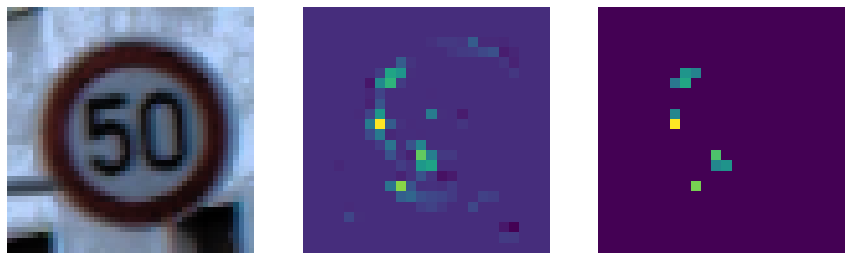

--------------------------------------------------
1
Predicted class by model and softplus:  41 41
Correct class:  41
Predicted class by model and softplus:  41 41
Correct class:  41


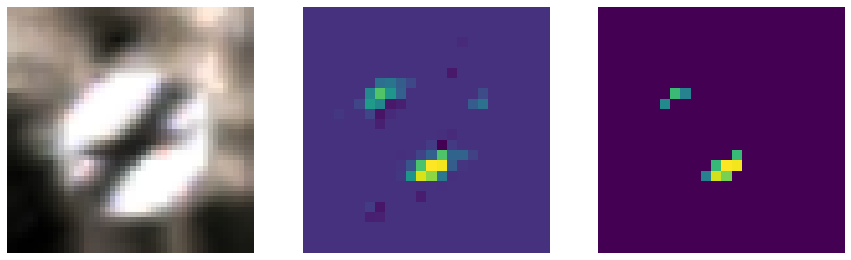

--------------------------------------------------
2
Predicted class by model and softplus:  36 36
Correct class:  36
Predicted class by model and softplus:  36 36
Correct class:  36


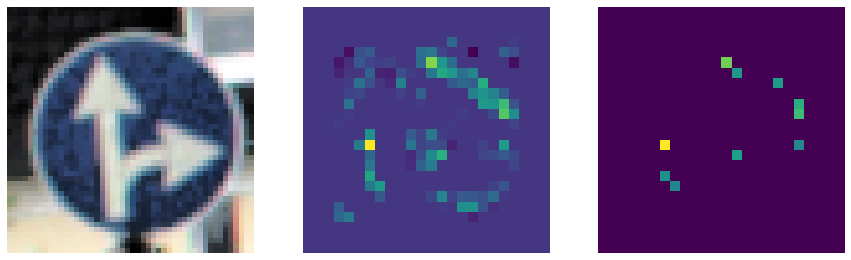

--------------------------------------------------
3
Predicted class by model and softplus:  26 26
Correct class:  26
Predicted class by model and softplus:  26 26
Correct class:  26


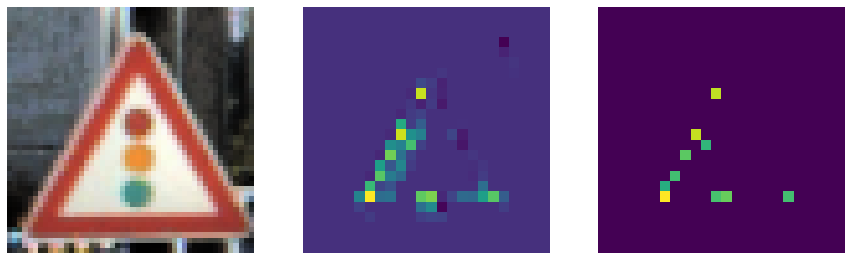

--------------------------------------------------
4
Predicted class by model and softplus:  29 29
Correct class:  22
Predicted class by model and softplus:  29 29
Correct class:  22


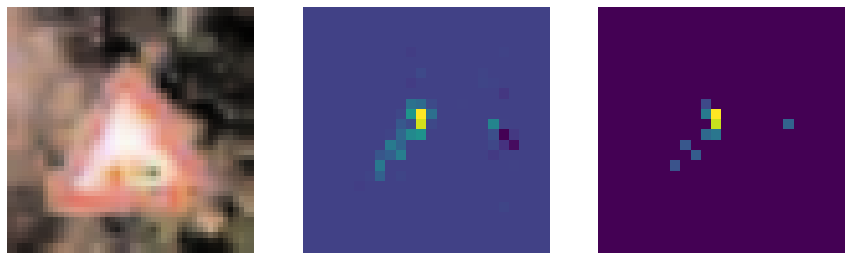

--------------------------------------------------
5
Predicted class by model and softplus:  2 2
Correct class:  2
Predicted class by model and softplus:  2 2
Correct class:  2


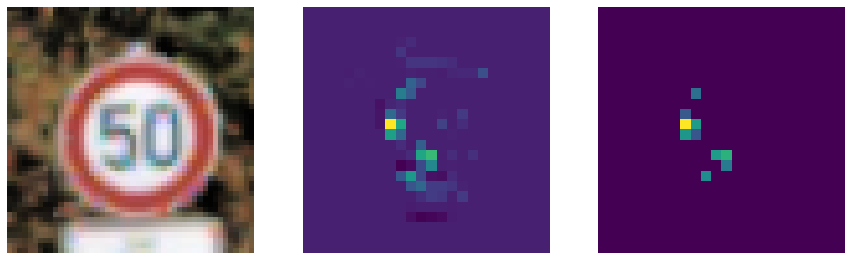

--------------------------------------------------
6
Predicted class by model and softplus:  28 28
Correct class:  28
Predicted class by model and softplus:  28 28
Correct class:  28


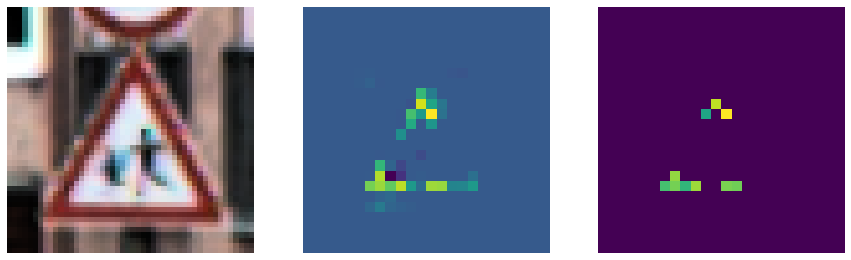

--------------------------------------------------
7
Predicted class by model and softplus:  13 13
Correct class:  13
Predicted class by model and softplus:  13 13
Correct class:  13


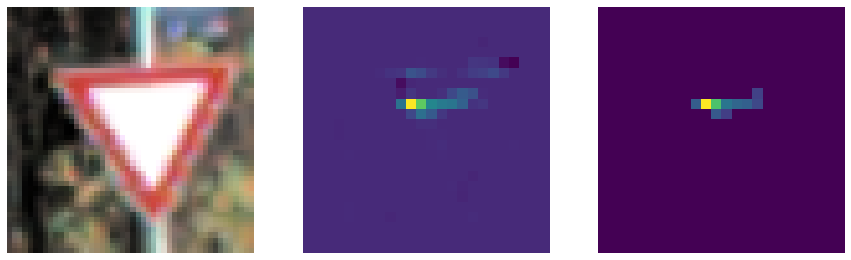

--------------------------------------------------
8
Predicted class by model and softplus:  5 5
Correct class:  5
Predicted class by model and softplus:  5 5
Correct class:  5


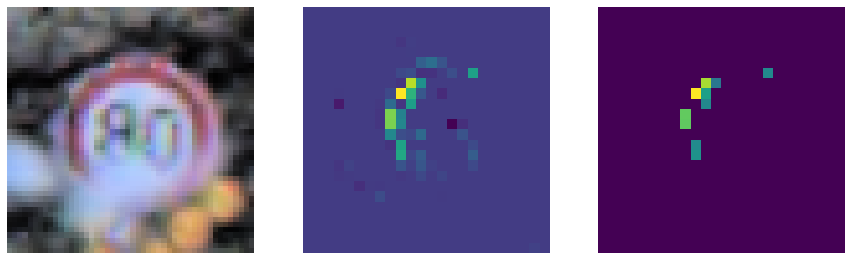

--------------------------------------------------
9
Predicted class by model and softplus:  5 5
Correct class:  7
Predicted class by model and softplus:  5 5
Correct class:  7


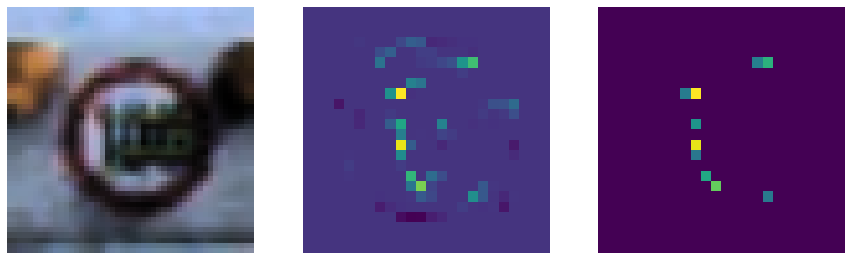

--------------------------------------------------
10
Predicted class by model and softplus:  3 3
Correct class:  3
Predicted class by model and softplus:  3 3
Correct class:  3


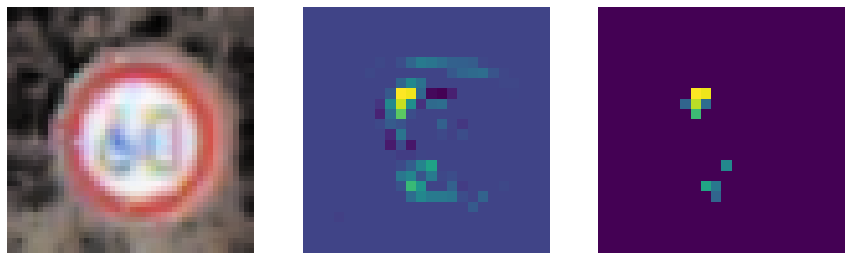

--------------------------------------------------
11
Predicted class by model and softplus:  20 20
Correct class:  20
Predicted class by model and softplus:  20 20
Correct class:  20


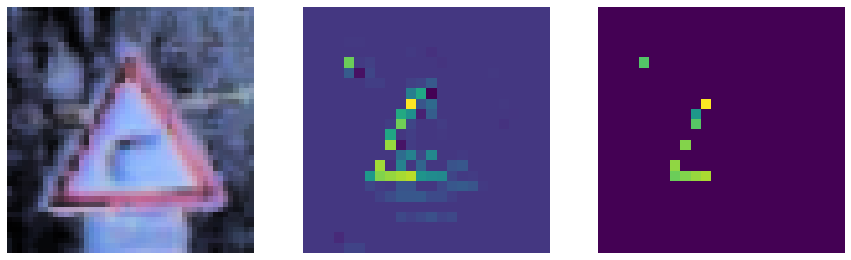

--------------------------------------------------
12
Predicted class by model and softplus:  35 35
Correct class:  35
Predicted class by model and softplus:  35 35
Correct class:  35


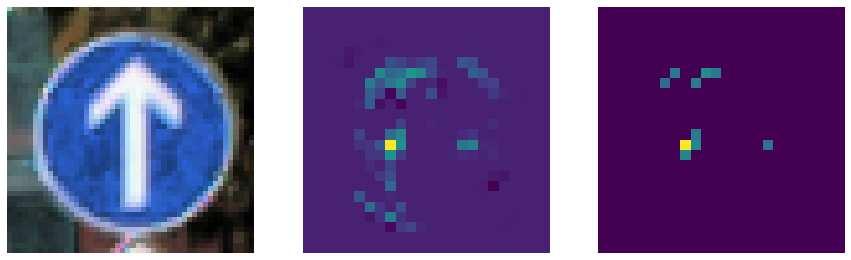

--------------------------------------------------
13
Predicted class by model and softplus:  13 13
Correct class:  13
Predicted class by model and softplus:  13 13
Correct class:  13


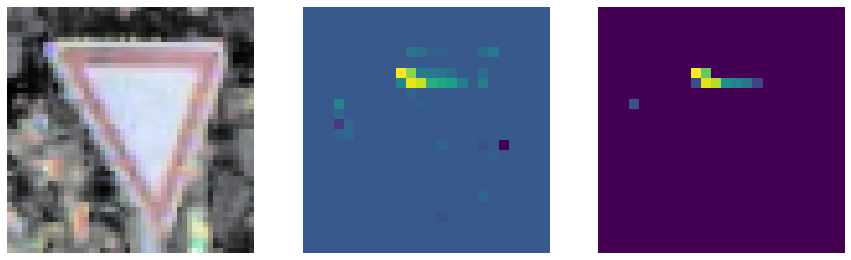

--------------------------------------------------
14
Predicted class by model and softplus:  25 25
Correct class:  25
Predicted class by model and softplus:  25 25
Correct class:  25


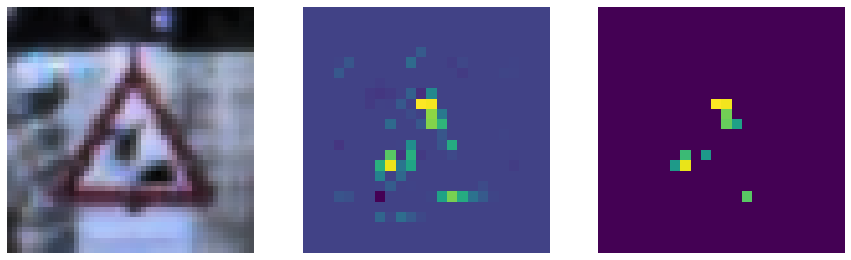

--------------------------------------------------
15
Predicted class by model and softplus:  8 8
Correct class:  8
Predicted class by model and softplus:  8 8
Correct class:  8


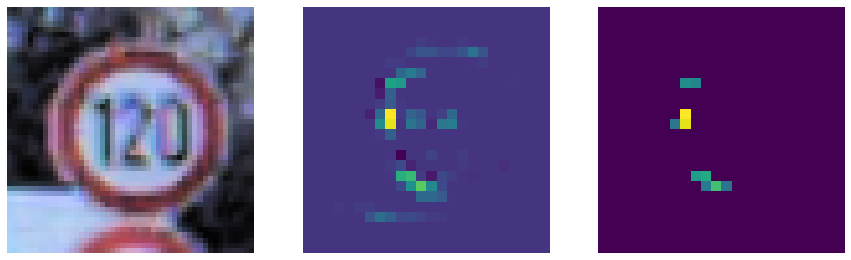

--------------------------------------------------
16
Predicted class by model and softplus:  10 10
Correct class:  10
Predicted class by model and softplus:  10 10
Correct class:  10


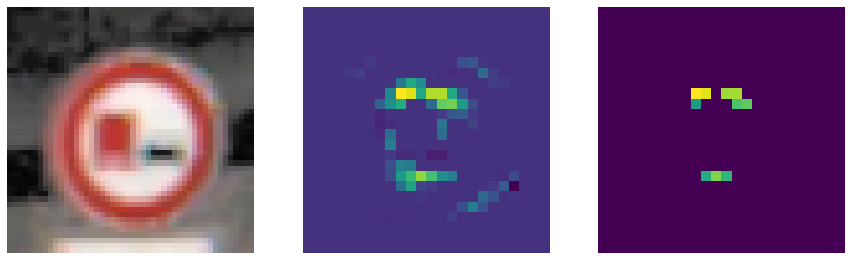

--------------------------------------------------
17
Predicted class by model and softplus:  10 10
Correct class:  10
Predicted class by model and softplus:  10 10
Correct class:  10


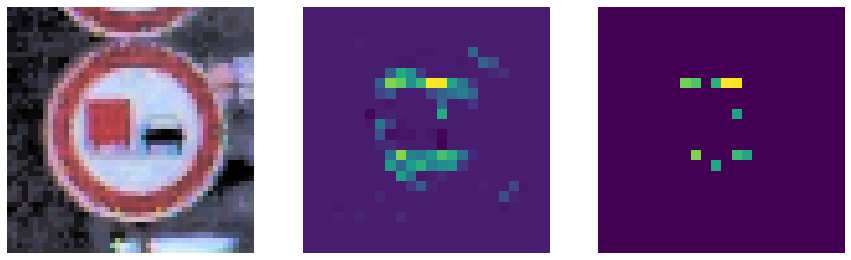

--------------------------------------------------
18
Predicted class by model and softplus:  38 38
Correct class:  38
Predicted class by model and softplus:  38 38
Correct class:  38


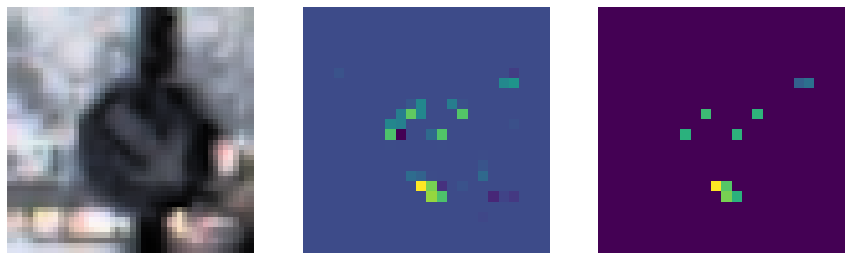

--------------------------------------------------
19
Predicted class by model and softplus:  38 38
Correct class:  38
Predicted class by model and softplus:  38 38
Correct class:  38


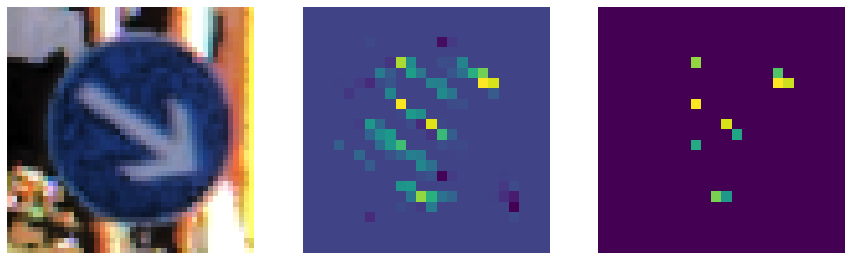

--------------------------------------------------
20
Predicted class by model and softplus:  36 36
Correct class:  36
Predicted class by model and softplus:  36 36
Correct class:  36


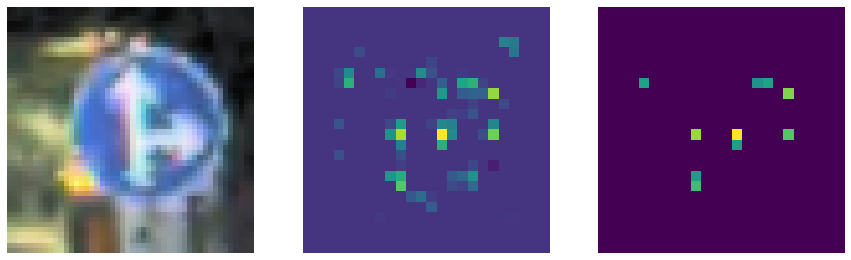

--------------------------------------------------
21
Predicted class by model and softplus:  2 2
Correct class:  2
Predicted class by model and softplus:  2 2
Correct class:  2


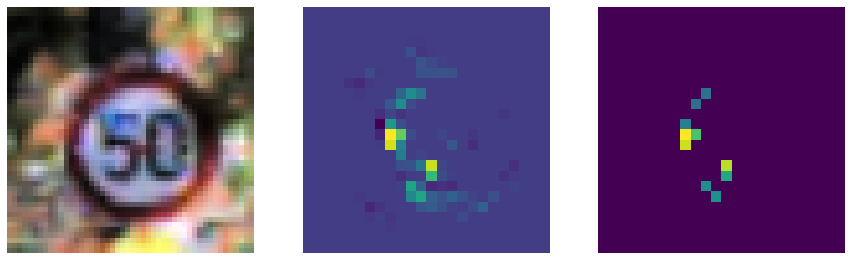

--------------------------------------------------
22
Predicted class by model and softplus:  37 37
Correct class:  37
Predicted class by model and softplus:  37 37
Correct class:  37


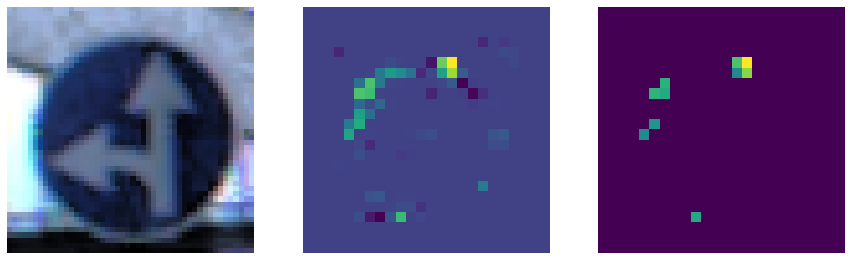

--------------------------------------------------
23
Predicted class by model and softplus:  36 36
Correct class:  36
Predicted class by model and softplus:  36 36
Correct class:  36


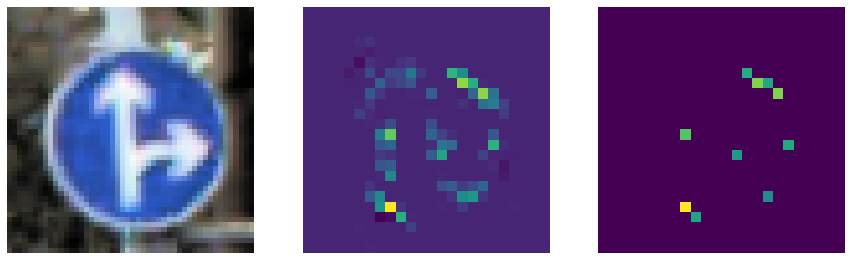

--------------------------------------------------
24
Predicted class by model and softplus:  33 33
Correct class:  33
Predicted class by model and softplus:  33 33
Correct class:  33


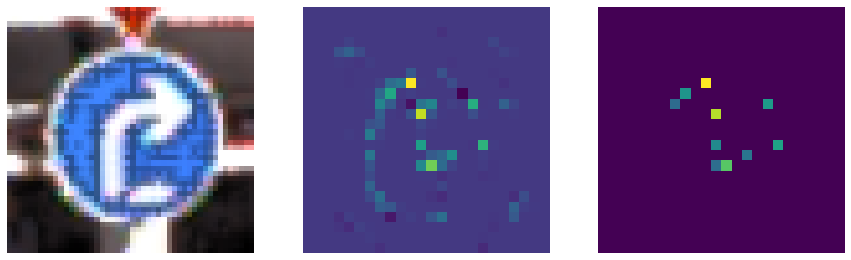

--------------------------------------------------
25
Predicted class by model and softplus:  28 28
Correct class:  28
Predicted class by model and softplus:  28 28
Correct class:  28


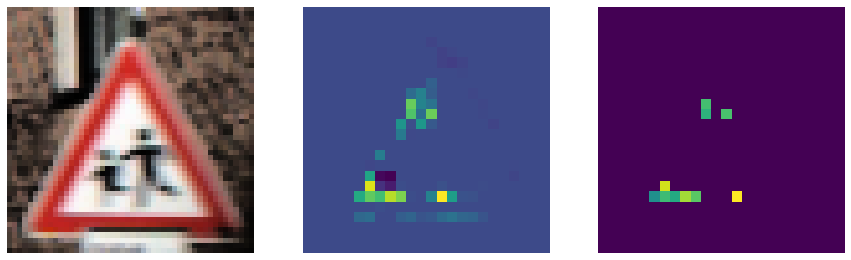

--------------------------------------------------
26
Predicted class by model and softplus:  29 29
Correct class:  29
Predicted class by model and softplus:  29 29
Correct class:  29


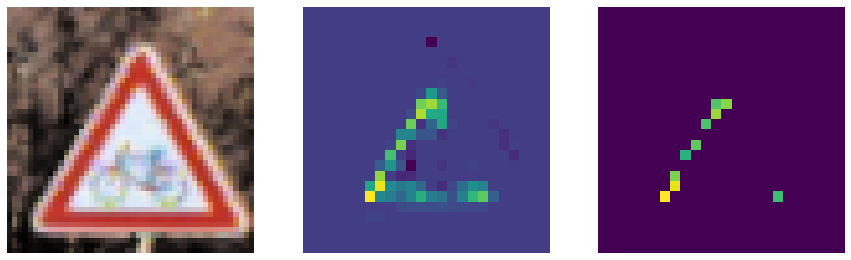

--------------------------------------------------
27
Predicted class by model and softplus:  23 23
Correct class:  23
Predicted class by model and softplus:  23 23
Correct class:  23


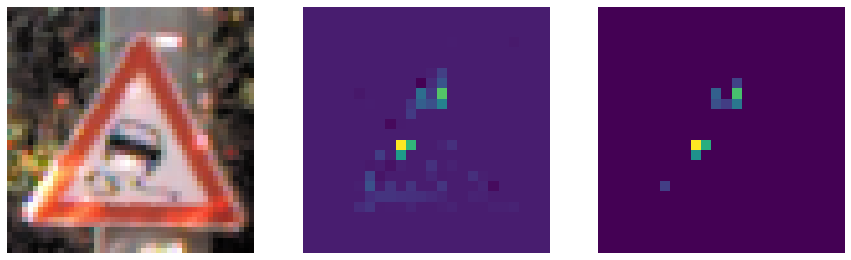

--------------------------------------------------
28
Predicted class by model and softplus:  5 5
Correct class:  5
Predicted class by model and softplus:  5 5
Correct class:  5


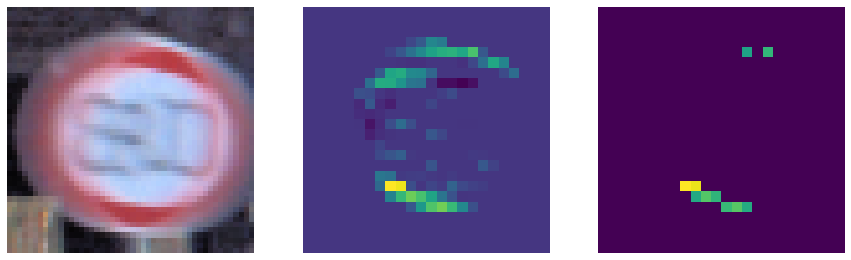

--------------------------------------------------
29
Predicted class by model and softplus:  38 38
Correct class:  38
Predicted class by model and softplus:  38 38
Correct class:  38


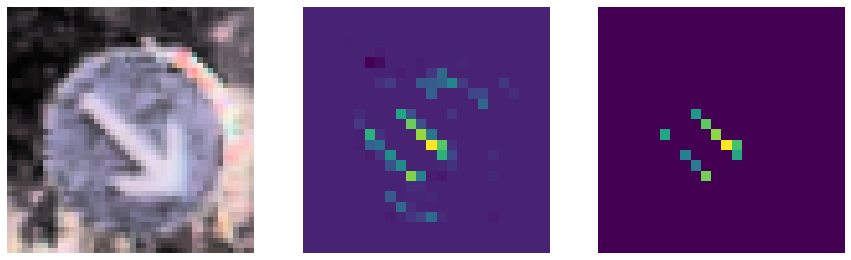

--------------------------------------------------
30
Predicted class by model and softplus:  35 35
Correct class:  35
Predicted class by model and softplus:  35 35
Correct class:  35


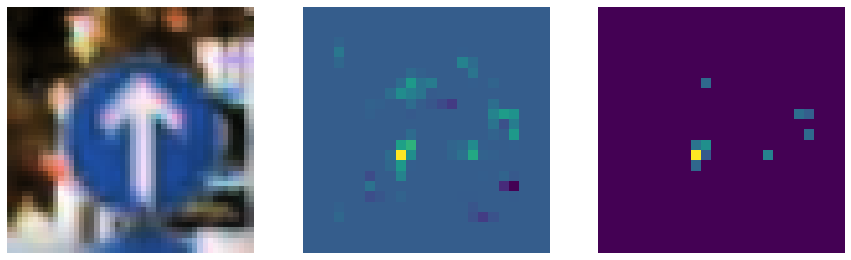

--------------------------------------------------
31
Predicted class by model and softplus:  15 15
Correct class:  15
Predicted class by model and softplus:  15 15
Correct class:  15


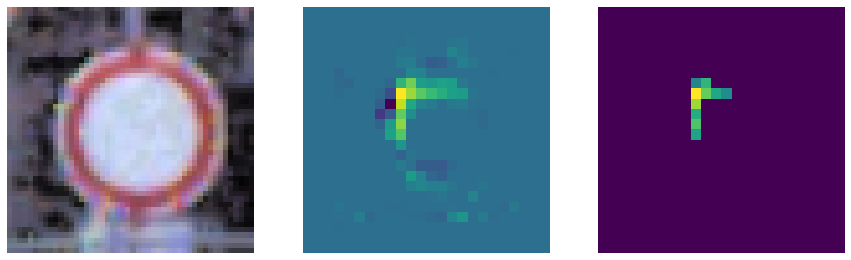

--------------------------------------------------
32
Predicted class by model and softplus:  5 5
Correct class:  5
Predicted class by model and softplus:  5 5
Correct class:  5


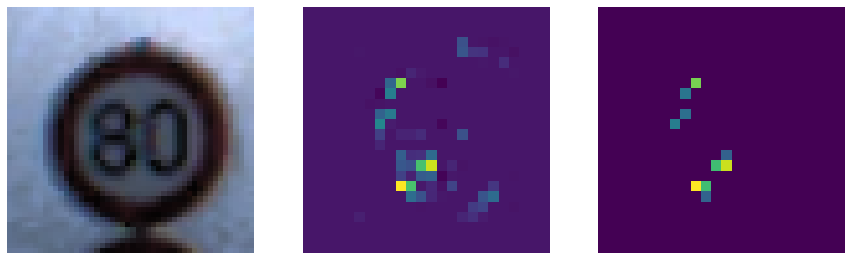

--------------------------------------------------
33
Predicted class by model and softplus:  12 12
Correct class:  12
Predicted class by model and softplus:  12 12
Correct class:  12


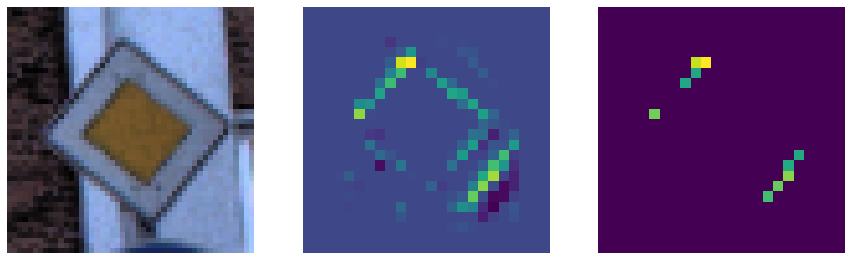

--------------------------------------------------
34
Predicted class by model and softplus:  37 37
Correct class:  37
Predicted class by model and softplus:  37 37
Correct class:  37


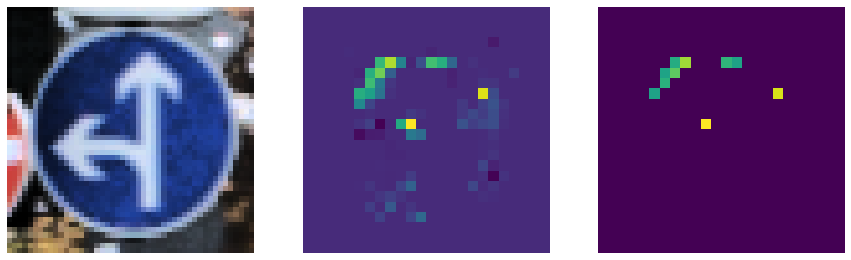

--------------------------------------------------
35
Predicted class by model and softplus:  35 35
Correct class:  35
Predicted class by model and softplus:  35 35
Correct class:  35


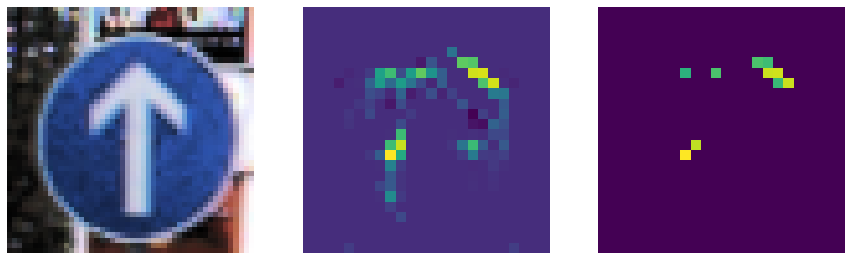

--------------------------------------------------
36
Predicted class by model and softplus:  18 18
Correct class:  18
Predicted class by model and softplus:  18 18
Correct class:  18


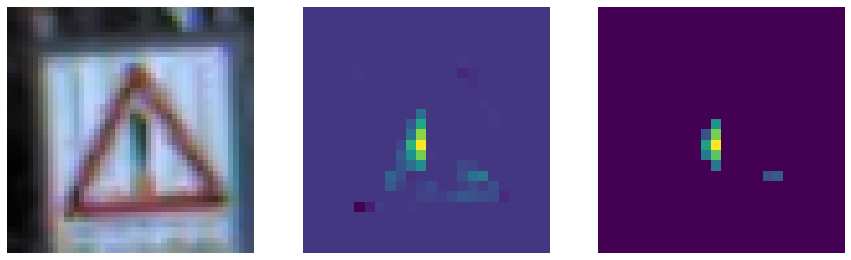

--------------------------------------------------
37
Predicted class by model and softplus:  12 12
Correct class:  12
Predicted class by model and softplus:  12 12
Correct class:  12


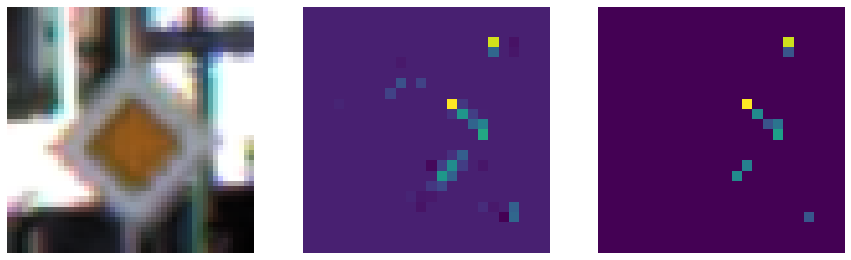

--------------------------------------------------
38
Predicted class by model and softplus:  6 6
Correct class:  6
Predicted class by model and softplus:  6 6
Correct class:  6


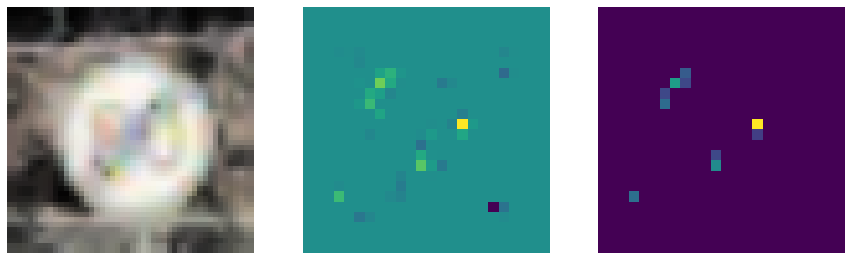

--------------------------------------------------
39
Predicted class by model and softplus:  25 25
Correct class:  25
Predicted class by model and softplus:  25 25
Correct class:  25


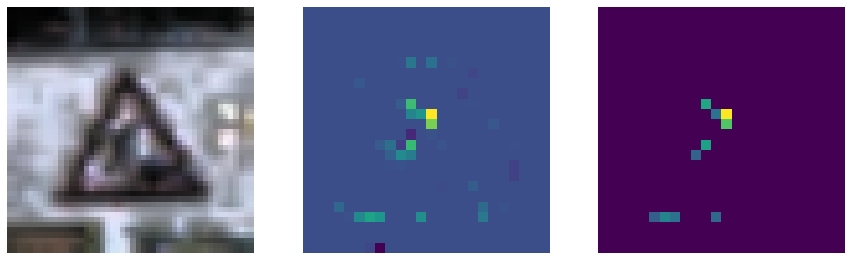

--------------------------------------------------
40
Predicted class by model and softplus:  4 4
Correct class:  4
Predicted class by model and softplus:  4 4
Correct class:  4


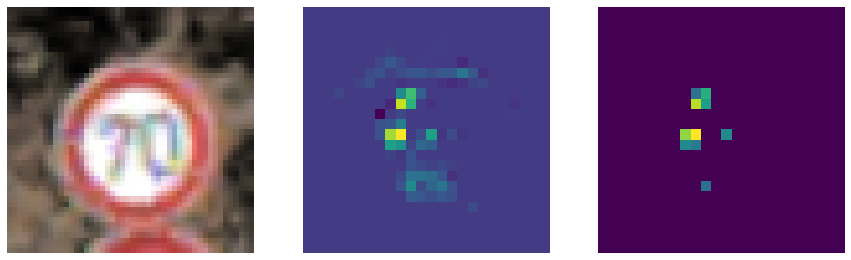

--------------------------------------------------
41
Predicted class by model and softplus:  29 29
Correct class:  29
Predicted class by model and softplus:  29 29
Correct class:  29


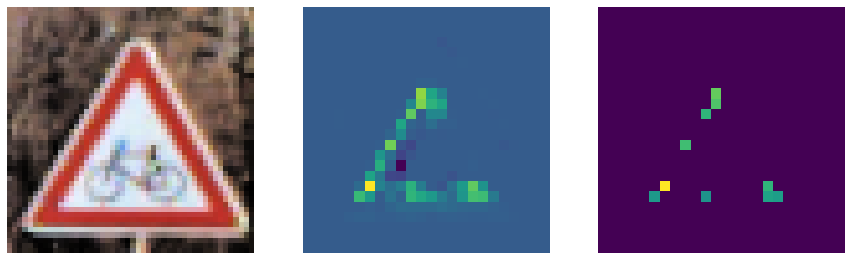

--------------------------------------------------
42
Predicted class by model and softplus:  9 9
Correct class:  9
Predicted class by model and softplus:  9 9
Correct class:  9


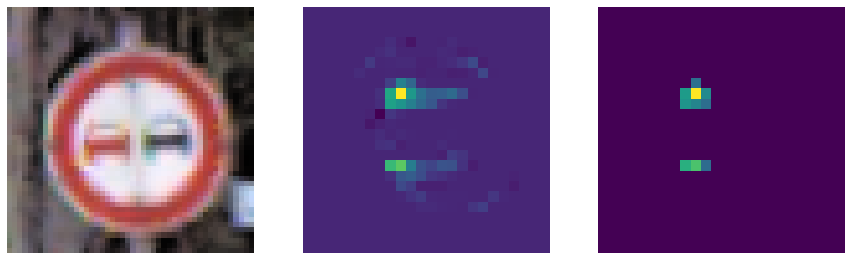

--------------------------------------------------
43
Predicted class by model and softplus:  13 13
Correct class:  13
Predicted class by model and softplus:  13 13
Correct class:  13


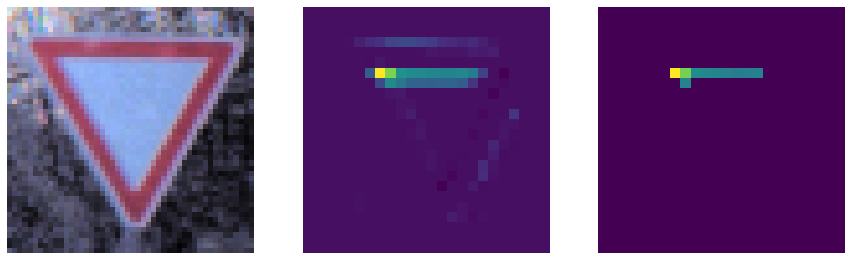

--------------------------------------------------
44
Predicted class by model and softplus:  25 25
Correct class:  25
Predicted class by model and softplus:  25 25
Correct class:  25


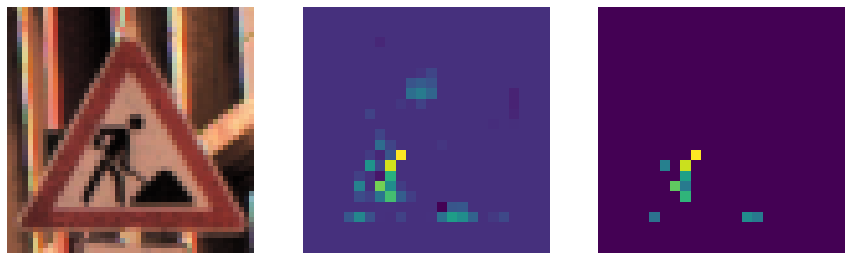

--------------------------------------------------
45
Predicted class by model and softplus:  11 11
Correct class:  11
Predicted class by model and softplus:  11 11
Correct class:  11


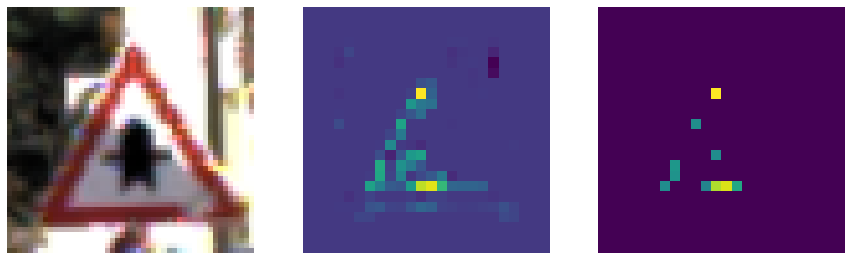

--------------------------------------------------
46
Predicted class by model and softplus:  8 8
Correct class:  8
Predicted class by model and softplus:  8 8
Correct class:  8


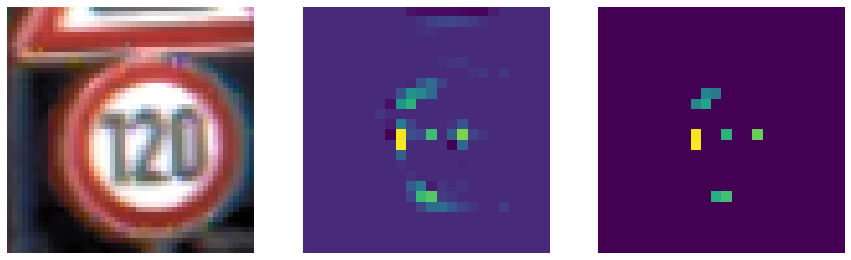

--------------------------------------------------
47
Predicted class by model and softplus:  10 10
Correct class:  10
Predicted class by model and softplus:  10 10
Correct class:  10


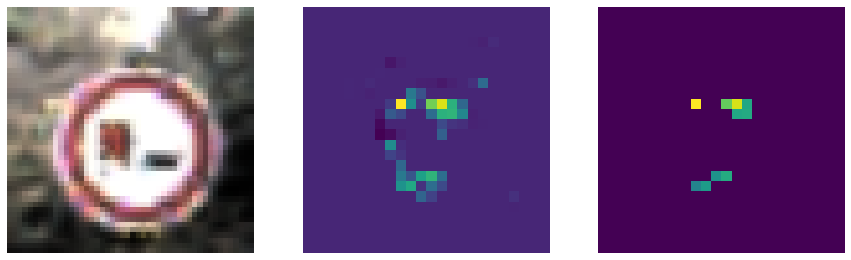

--------------------------------------------------
48
Predicted class by model and softplus:  38 38
Correct class:  38
Predicted class by model and softplus:  38 38
Correct class:  38


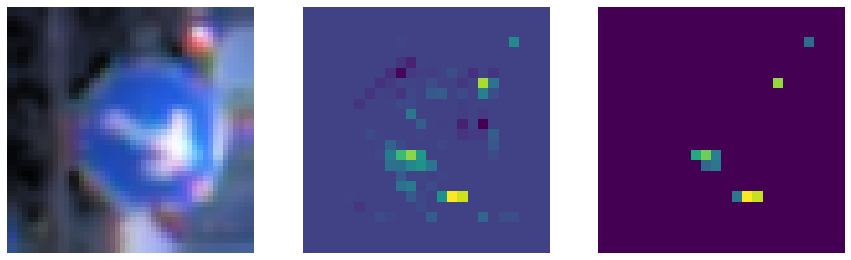

--------------------------------------------------
49
Predicted class by model and softplus:  3 3
Correct class:  3
Predicted class by model and softplus:  3 3
Correct class:  3


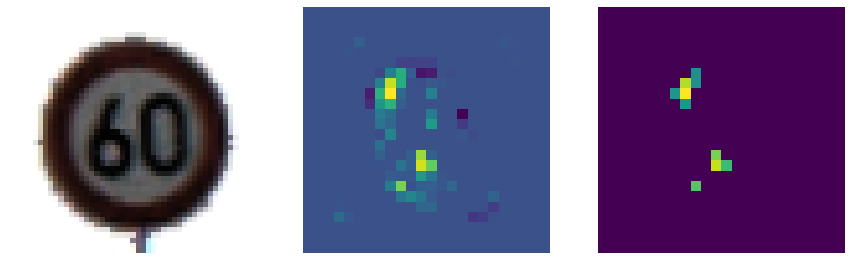

--------------------------------------------------
50
Predicted class by model and softplus:  7 7
Correct class:  7
Predicted class by model and softplus:  7 7
Correct class:  7


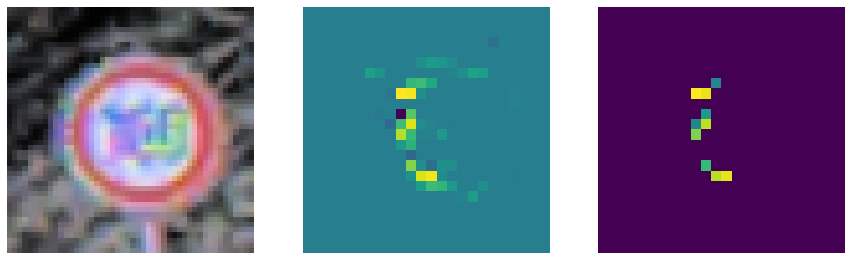

--------------------------------------------------
51
Predicted class by model and softplus:  7 7
Correct class:  7
Predicted class by model and softplus:  7 7
Correct class:  7


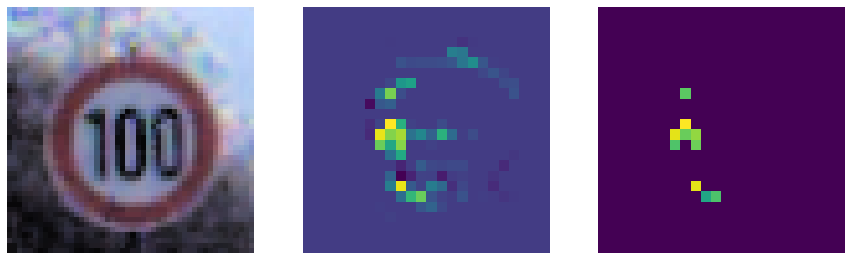

--------------------------------------------------
52
Predicted class by model and softplus:  33 33
Correct class:  33
Predicted class by model and softplus:  33 33
Correct class:  33


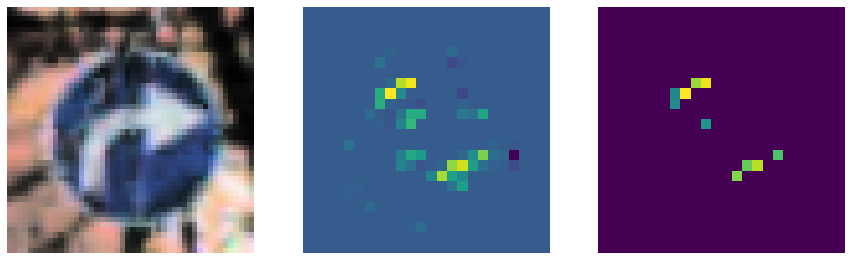

--------------------------------------------------
53
Predicted class by model and softplus:  15 15
Correct class:  15
Predicted class by model and softplus:  15 15
Correct class:  15


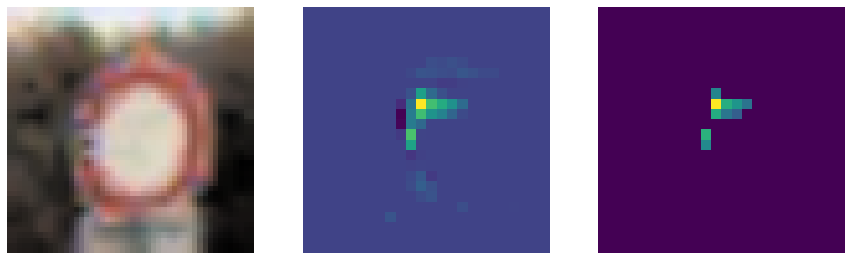

--------------------------------------------------
54
Predicted class by model and softplus:  9 9
Correct class:  9
Predicted class by model and softplus:  9 9
Correct class:  9


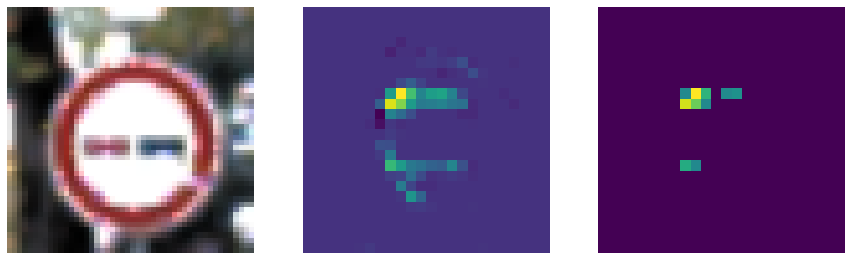

--------------------------------------------------
55
Predicted class by model and softplus:  6 6
Correct class:  6
Predicted class by model and softplus:  6 6
Correct class:  6


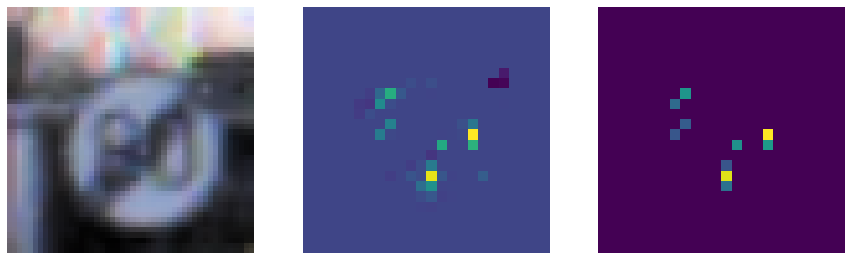

--------------------------------------------------
56
Predicted class by model and softplus:  1 1
Correct class:  1
Predicted class by model and softplus:  1 1
Correct class:  1


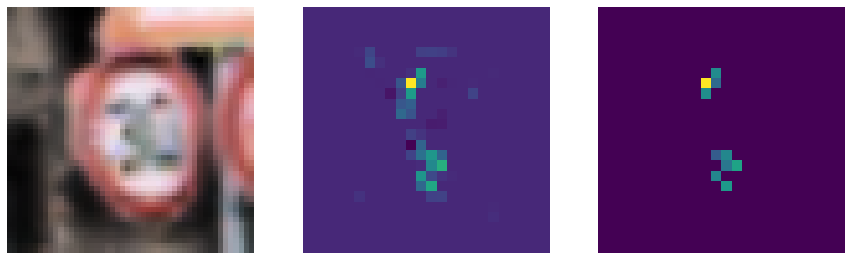

--------------------------------------------------
57
Predicted class by model and softplus:  21 21
Correct class:  21
Predicted class by model and softplus:  21 21
Correct class:  21


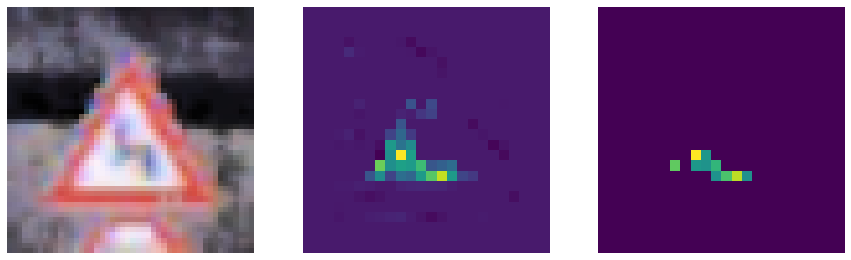

--------------------------------------------------
58
Predicted class by model and softplus:  25 25
Correct class:  25
Predicted class by model and softplus:  25 25
Correct class:  25


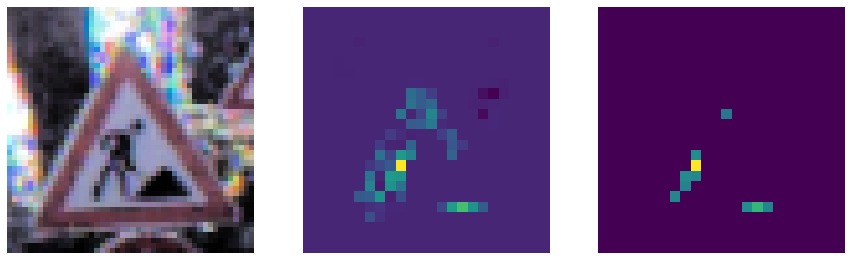

--------------------------------------------------
59
Predicted class by model and softplus:  18 18
Correct class:  18
Predicted class by model and softplus:  18 18
Correct class:  18


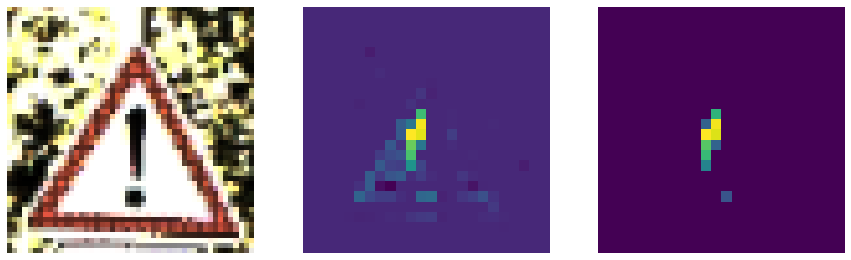

--------------------------------------------------
60
Predicted class by model and softplus:  2 2
Correct class:  2
Predicted class by model and softplus:  2 2
Correct class:  2


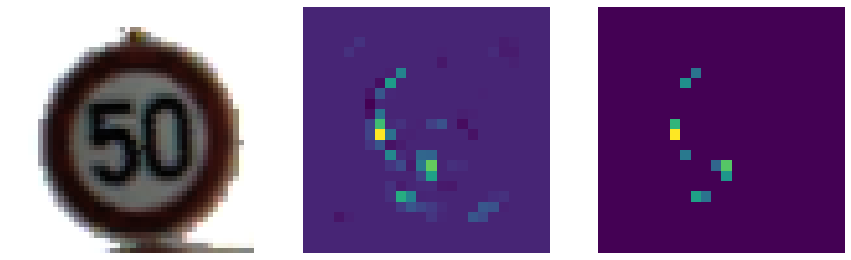

--------------------------------------------------
61
Predicted class by model and softplus:  42 42
Correct class:  42
Predicted class by model and softplus:  42 42
Correct class:  42


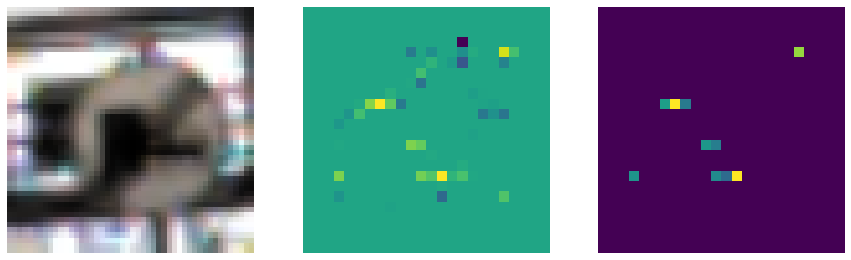

--------------------------------------------------
62
Predicted class by model and softplus:  35 35
Correct class:  35
Predicted class by model and softplus:  35 35
Correct class:  35


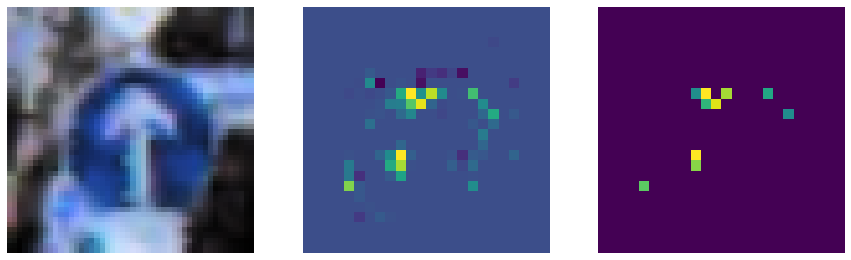

--------------------------------------------------
63
Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


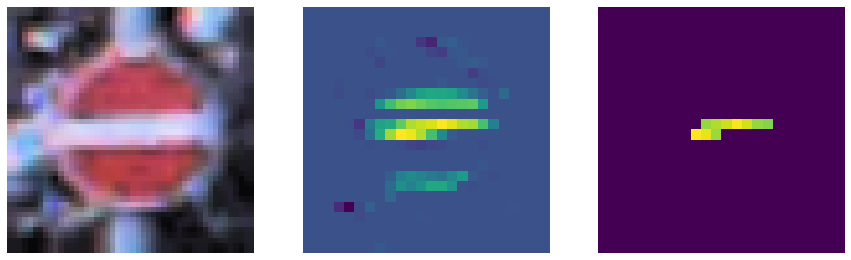

--------------------------------------------------
64
Predicted class by model and softplus:  40 40
Correct class:  40
Predicted class by model and softplus:  40 40
Correct class:  40


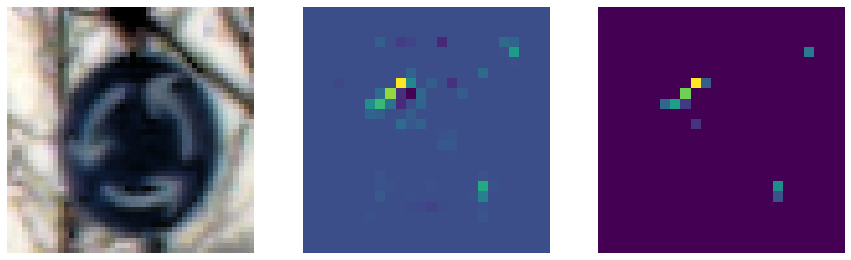

--------------------------------------------------
65
Predicted class by model and softplus:  38 38
Correct class:  38
Predicted class by model and softplus:  38 38
Correct class:  38


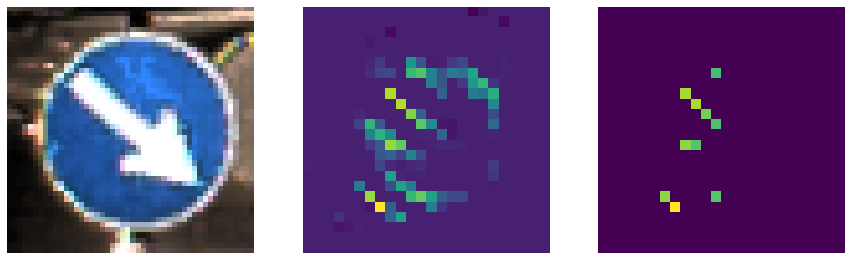

--------------------------------------------------
66
Predicted class by model and softplus:  5 5
Correct class:  5
Predicted class by model and softplus:  5 5
Correct class:  5


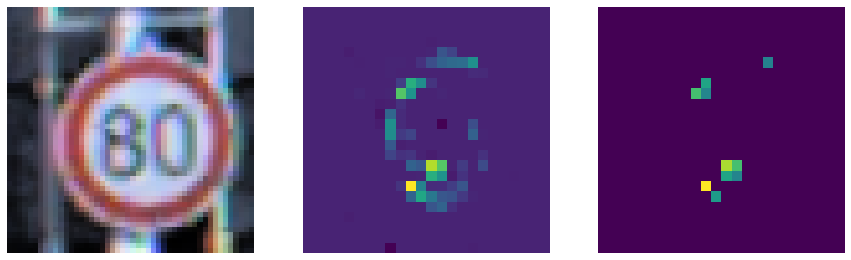

--------------------------------------------------
67
Predicted class by model and softplus:  13 13
Correct class:  13
Predicted class by model and softplus:  13 13
Correct class:  13


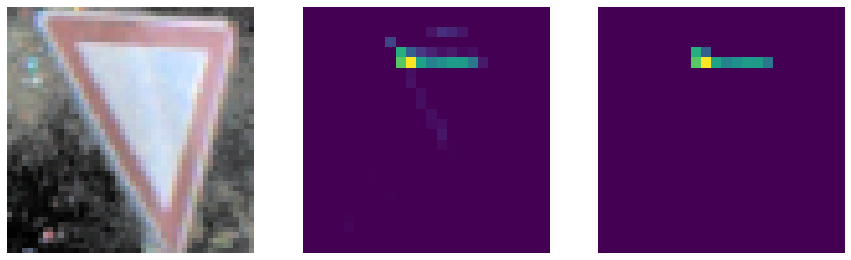

--------------------------------------------------
68
Predicted class by model and softplus:  12 12
Correct class:  12
Predicted class by model and softplus:  12 12
Correct class:  12


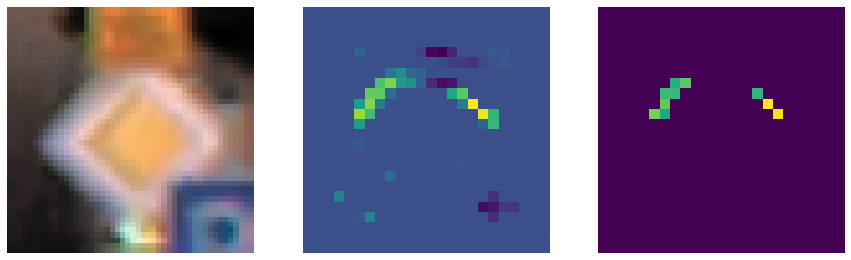

--------------------------------------------------
69
Predicted class by model and softplus:  1 1
Correct class:  1
Predicted class by model and softplus:  1 1
Correct class:  1


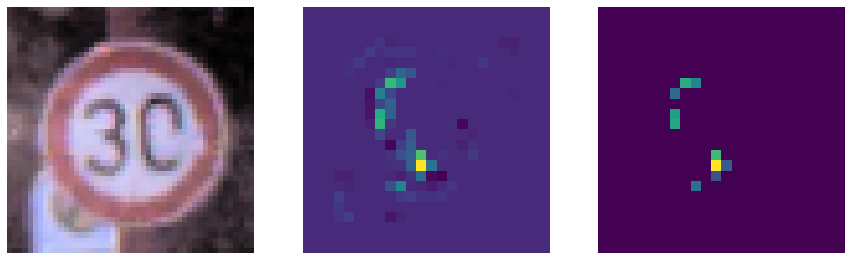

--------------------------------------------------
70
Predicted class by model and softplus:  2 2
Correct class:  2
Predicted class by model and softplus:  2 2
Correct class:  2


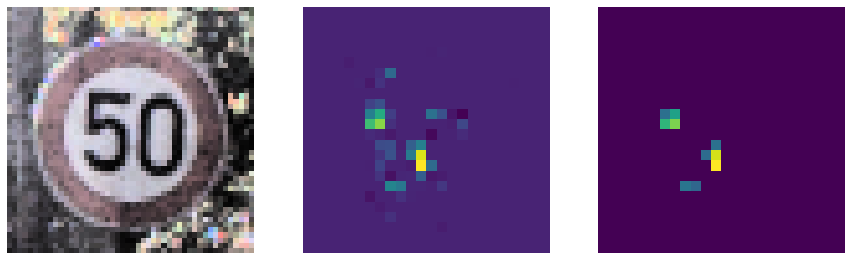

--------------------------------------------------
71
Predicted class by model and softplus:  39 39
Correct class:  39
Predicted class by model and softplus:  39 39
Correct class:  39


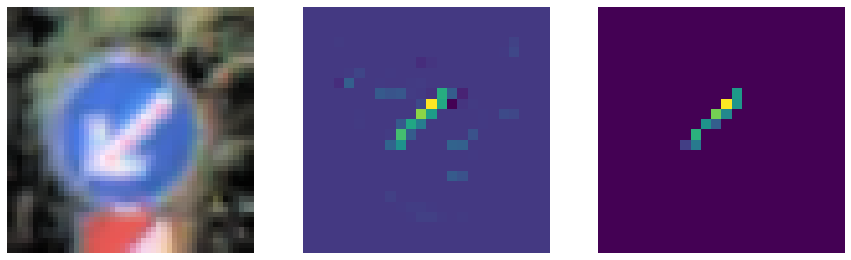

--------------------------------------------------
72
Predicted class by model and softplus:  26 26
Correct class:  26
Predicted class by model and softplus:  26 26
Correct class:  26


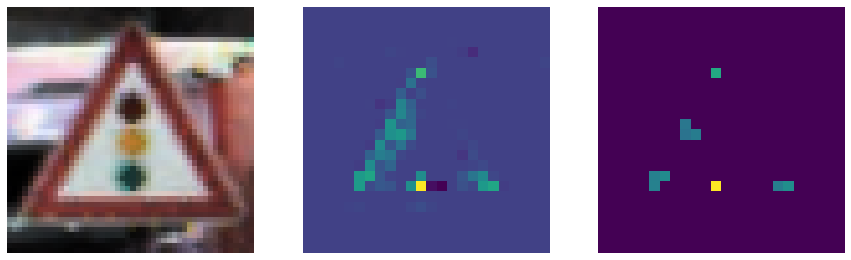

--------------------------------------------------
73
Predicted class by model and softplus:  9 9
Correct class:  9
Predicted class by model and softplus:  9 9
Correct class:  9


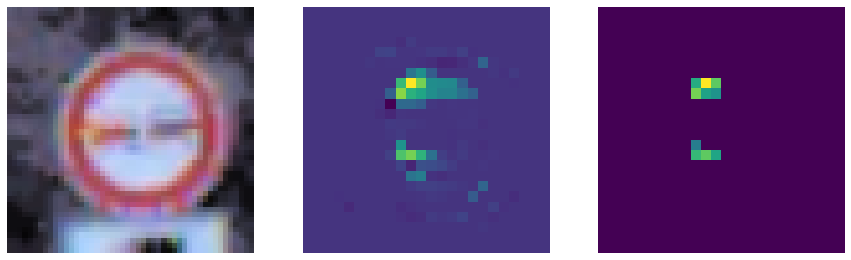

--------------------------------------------------
74
Predicted class by model and softplus:  1 1
Correct class:  1
Predicted class by model and softplus:  1 1
Correct class:  1


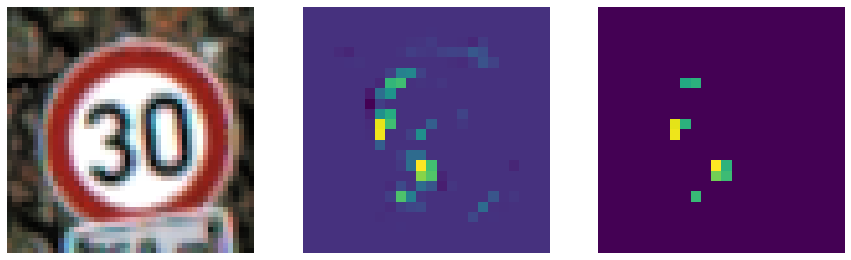

--------------------------------------------------
75
Predicted class by model and softplus:  11 11
Correct class:  11
Predicted class by model and softplus:  11 11
Correct class:  11


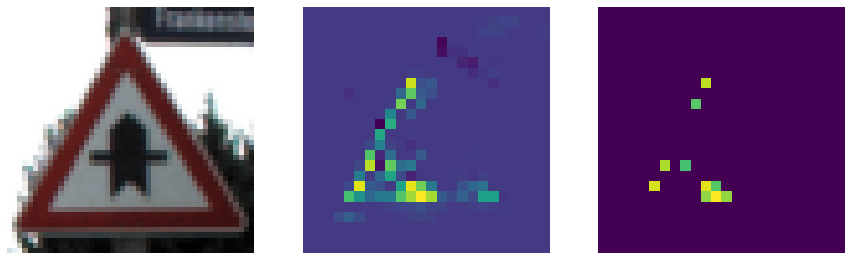

--------------------------------------------------
76
Predicted class by model and softplus:  1 1
Correct class:  1
Predicted class by model and softplus:  1 1
Correct class:  1


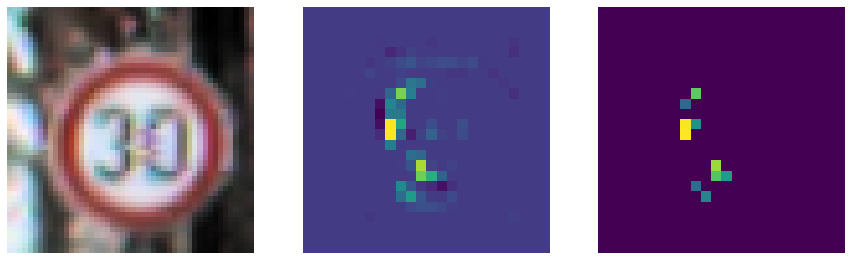

--------------------------------------------------
77
Predicted class by model and softplus:  14 14
Correct class:  14
Predicted class by model and softplus:  14 14
Correct class:  14


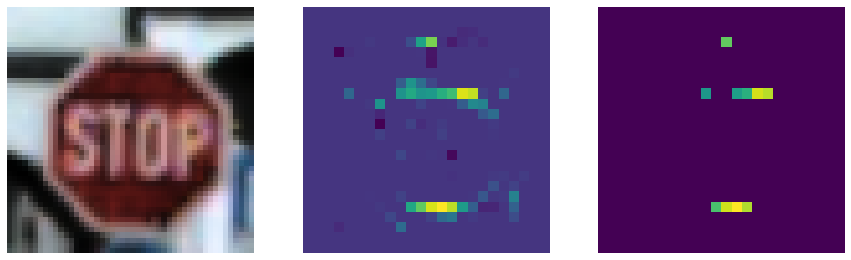

--------------------------------------------------
78
Predicted class by model and softplus:  3 3
Correct class:  3
Predicted class by model and softplus:  3 3
Correct class:  3


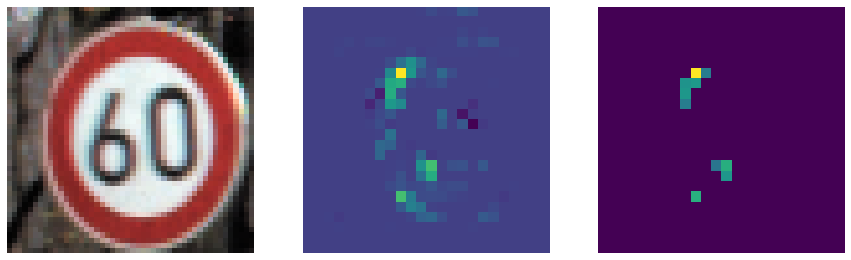

--------------------------------------------------
79
Predicted class by model and softplus:  8 8
Correct class:  8
Predicted class by model and softplus:  8 8
Correct class:  8


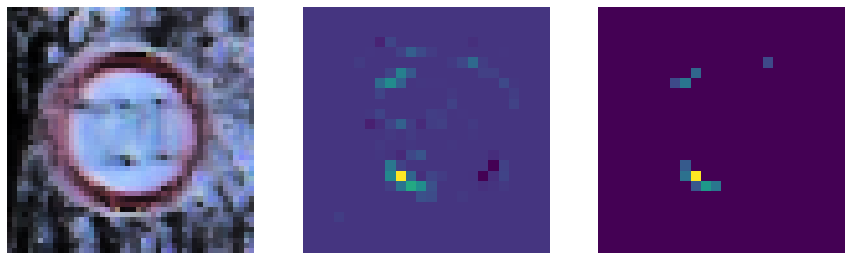

--------------------------------------------------
80
Predicted class by model and softplus:  11 11
Correct class:  11
Predicted class by model and softplus:  11 11
Correct class:  11


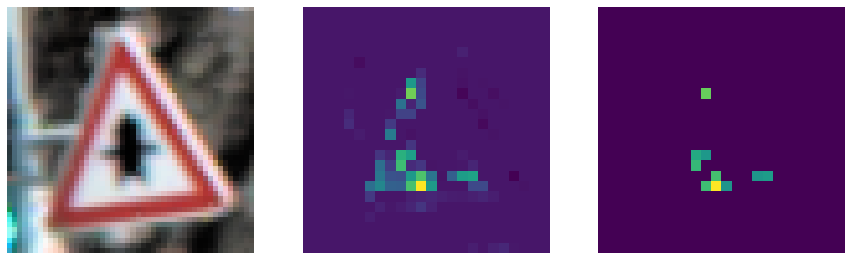

--------------------------------------------------
81
Predicted class by model and softplus:  12 12
Correct class:  12
Predicted class by model and softplus:  12 12
Correct class:  12


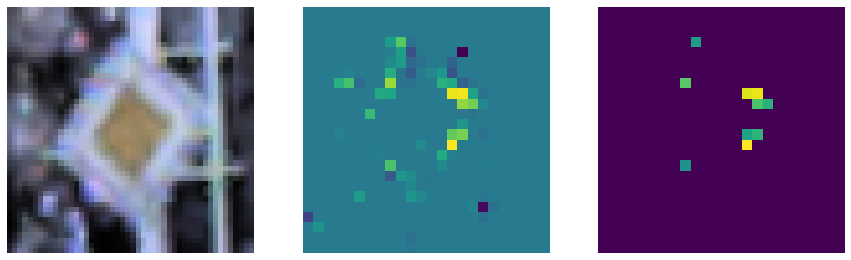

--------------------------------------------------
82
Predicted class by model and softplus:  37 37
Correct class:  37
Predicted class by model and softplus:  37 37
Correct class:  37


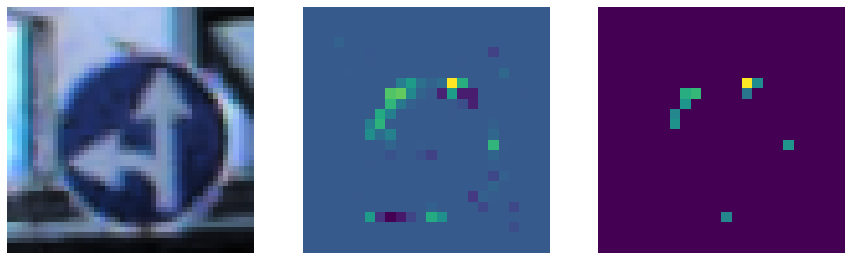

--------------------------------------------------
83
Predicted class by model and softplus:  28 28
Correct class:  28
Predicted class by model and softplus:  28 28
Correct class:  28


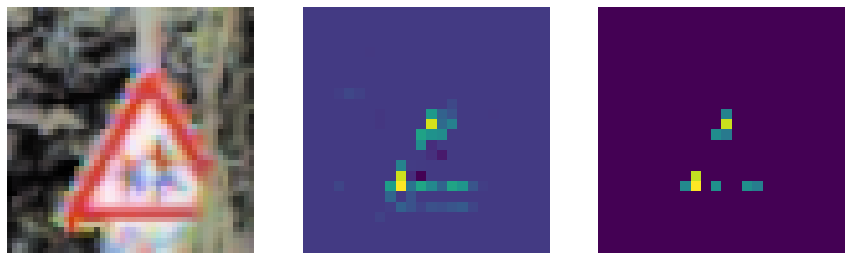

--------------------------------------------------
84
Predicted class by model and softplus:  30 30
Correct class:  30
Predicted class by model and softplus:  30 30
Correct class:  30


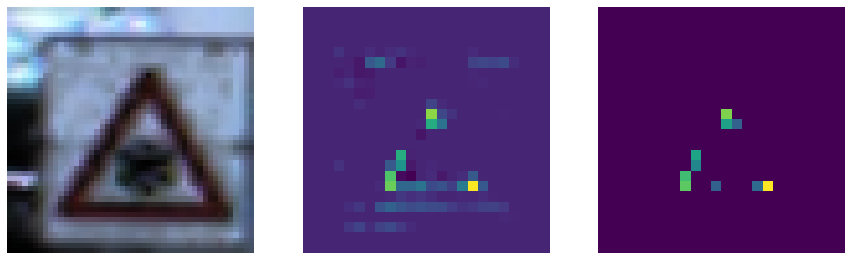

--------------------------------------------------
85
Predicted class by model and softplus:  28 28
Correct class:  28
Predicted class by model and softplus:  28 28
Correct class:  28


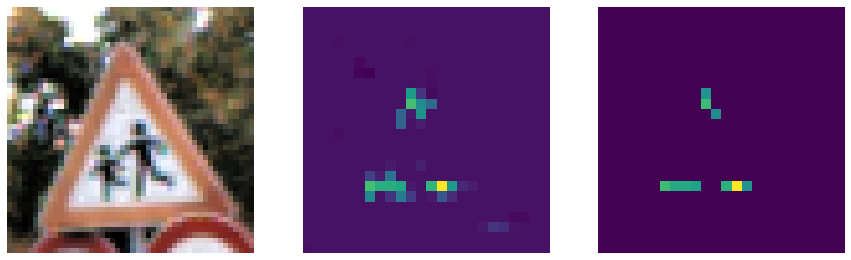

--------------------------------------------------
86
Predicted class by model and softplus:  35 35
Correct class:  35
Predicted class by model and softplus:  35 35
Correct class:  35


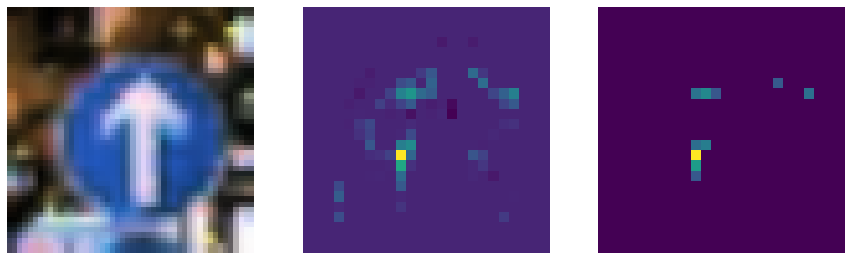

--------------------------------------------------
87
Predicted class by model and softplus:  4 4
Correct class:  4
Predicted class by model and softplus:  4 4
Correct class:  4


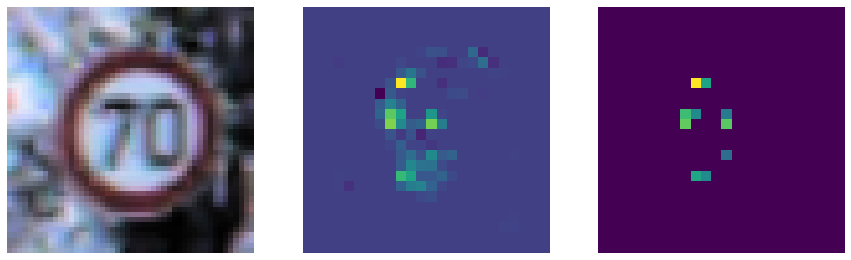

--------------------------------------------------
88
Predicted class by model and softplus:  10 10
Correct class:  14
Predicted class by model and softplus:  10 10
Correct class:  14


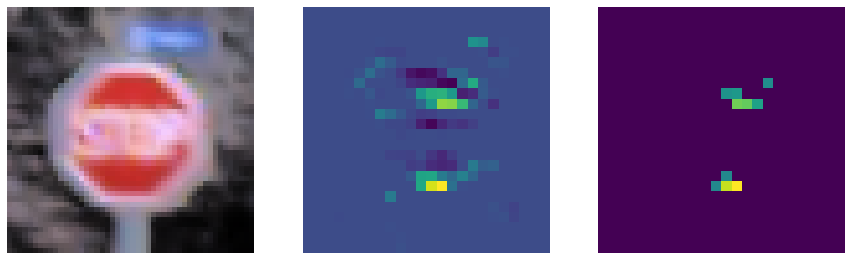

--------------------------------------------------
89
Predicted class by model and softplus:  2 2
Correct class:  2
Predicted class by model and softplus:  2 2
Correct class:  2


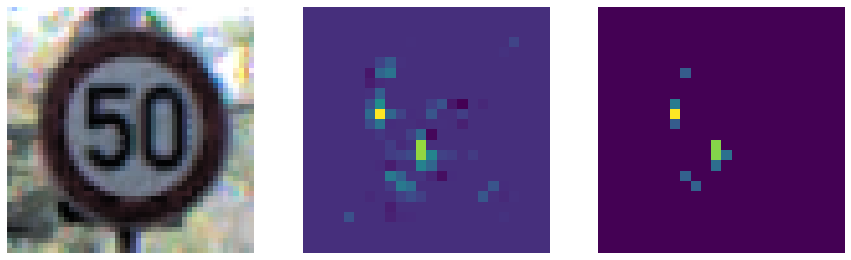

--------------------------------------------------
90
Predicted class by model and softplus:  16 16
Correct class:  16
Predicted class by model and softplus:  16 16
Correct class:  16


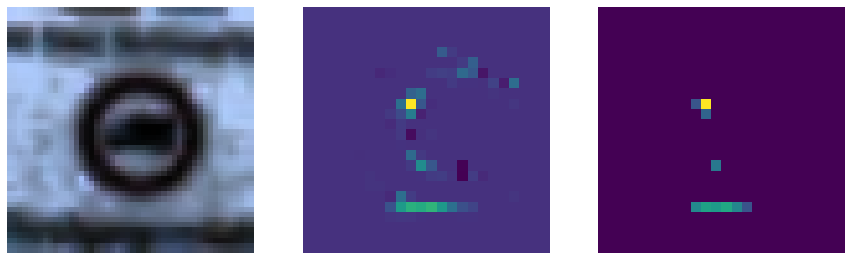

--------------------------------------------------
91
Predicted class by model and softplus:  18 18
Correct class:  18
Predicted class by model and softplus:  18 18
Correct class:  18


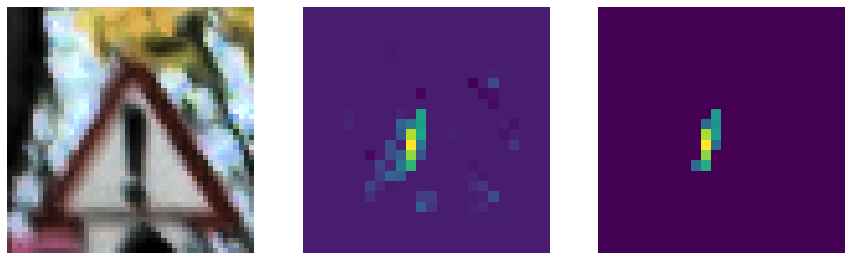

--------------------------------------------------
92
Predicted class by model and softplus:  16 16
Correct class:  16
Predicted class by model and softplus:  16 16
Correct class:  16


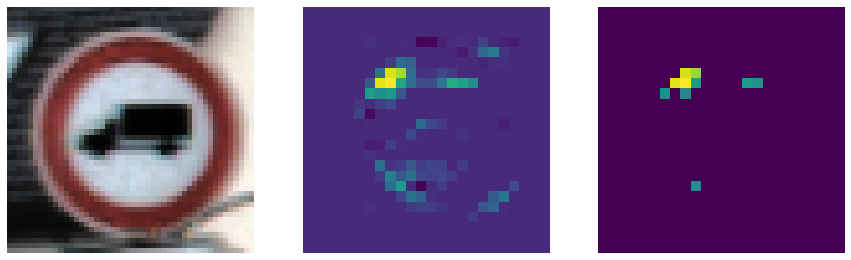

--------------------------------------------------
93
Predicted class by model and softplus:  8 8
Correct class:  8
Predicted class by model and softplus:  8 8
Correct class:  8


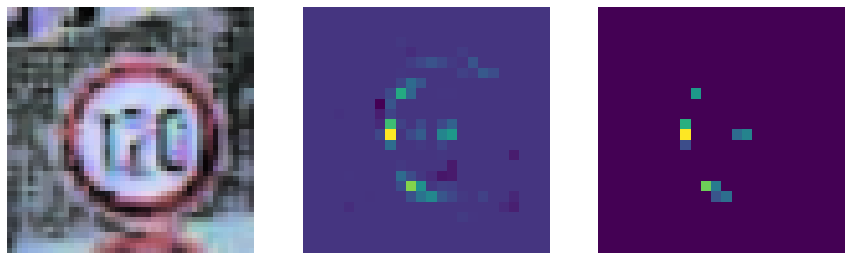

--------------------------------------------------
94
Predicted class by model and softplus:  1 1
Correct class:  1
Predicted class by model and softplus:  1 1
Correct class:  1


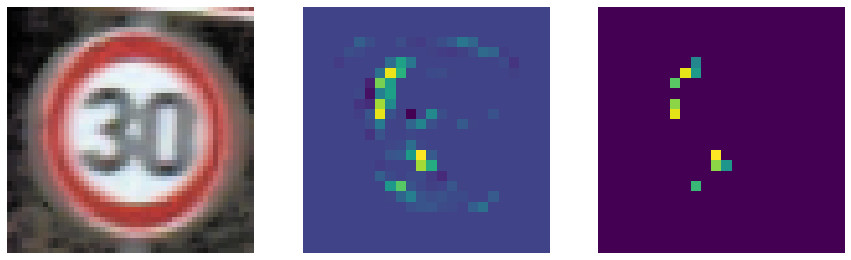

--------------------------------------------------
95
Predicted class by model and softplus:  12 12
Correct class:  12
Predicted class by model and softplus:  12 12
Correct class:  12


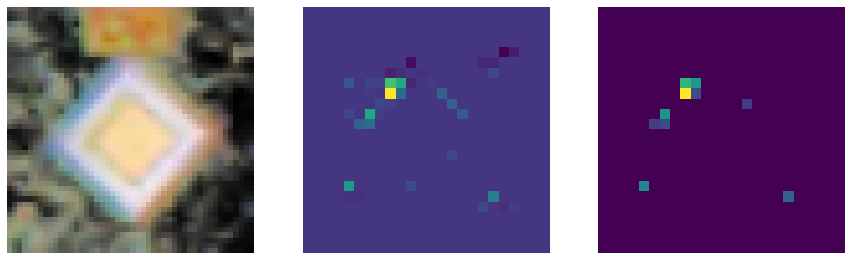

--------------------------------------------------
96
Predicted class by model and softplus:  8 8
Correct class:  8
Predicted class by model and softplus:  8 8
Correct class:  8


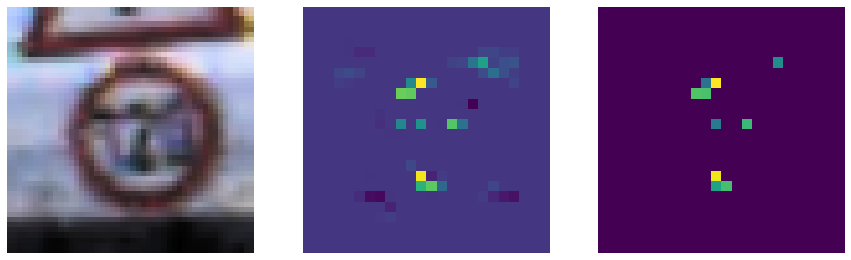

--------------------------------------------------
97
Predicted class by model and softplus:  11 11
Correct class:  11
Predicted class by model and softplus:  11 11
Correct class:  11


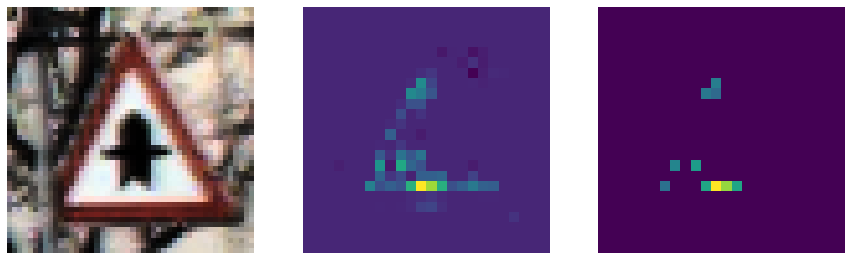

--------------------------------------------------
98
Predicted class by model and softplus:  8 8
Correct class:  7
Predicted class by model and softplus:  8 8
Correct class:  7


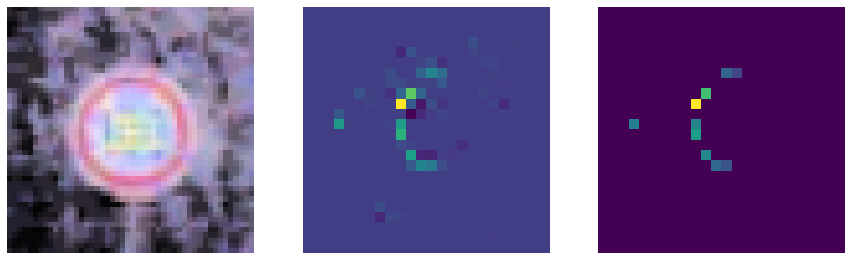

--------------------------------------------------
99
Predicted class by model and softplus:  41 41
Correct class:  41
Predicted class by model and softplus:  41 41
Correct class:  41


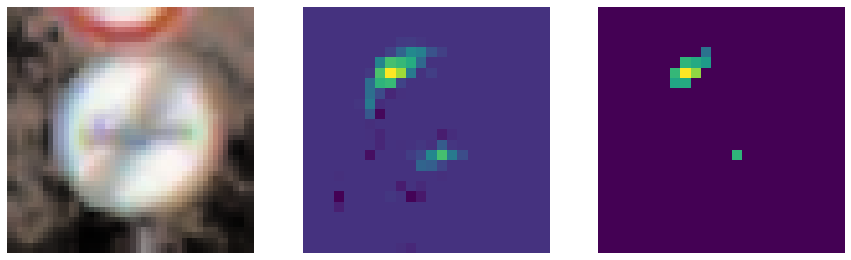

--------------------------------------------------
100
Predicted class by model and softplus:  5 5
Correct class:  5
Predicted class by model and softplus:  5 5
Correct class:  5


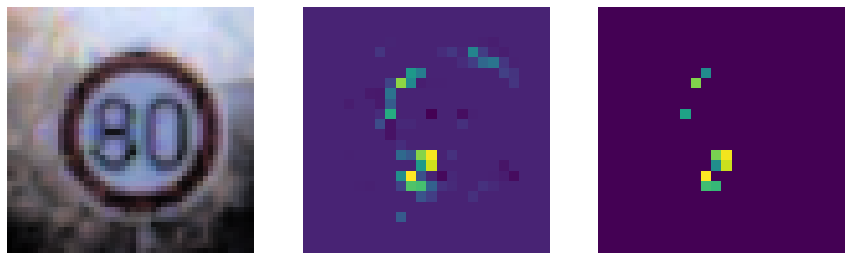

--------------------------------------------------
101
Predicted class by model and softplus:  35 35
Correct class:  35
Predicted class by model and softplus:  35 35
Correct class:  35


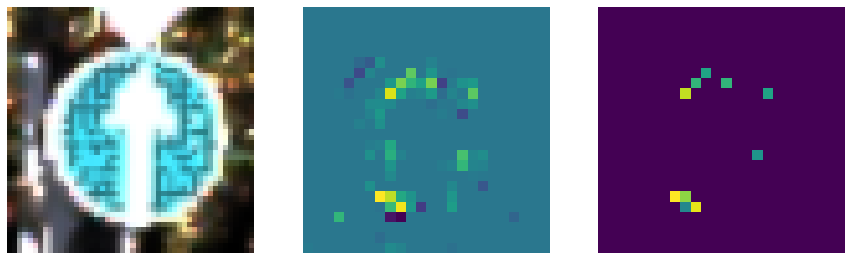

--------------------------------------------------
102
Predicted class by model and softplus:  7 7
Correct class:  7
Predicted class by model and softplus:  7 7
Correct class:  7


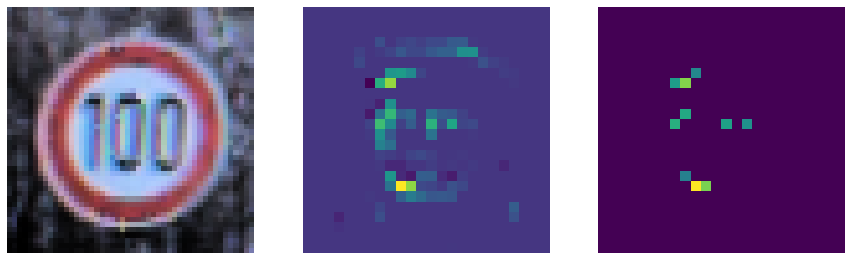

--------------------------------------------------
103
Predicted class by model and softplus:  31 31
Correct class:  31
Predicted class by model and softplus:  31 31
Correct class:  31


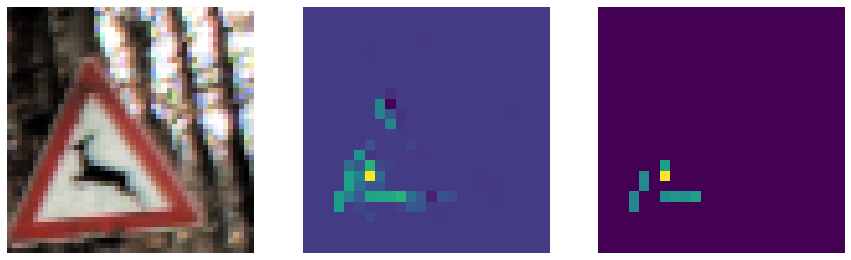

--------------------------------------------------
104
Predicted class by model and softplus:  8 8
Correct class:  8
Predicted class by model and softplus:  8 8
Correct class:  8


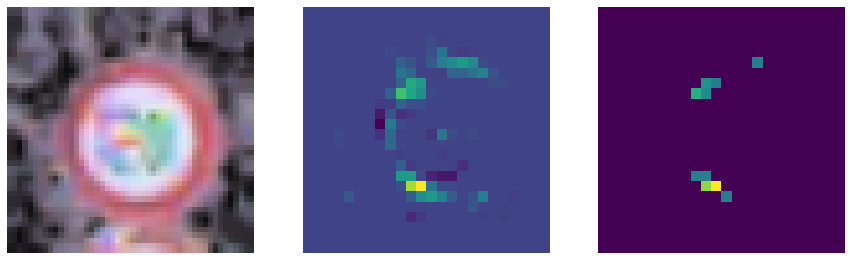

--------------------------------------------------
105
Predicted class by model and softplus:  29 29
Correct class:  29
Predicted class by model and softplus:  29 29
Correct class:  29


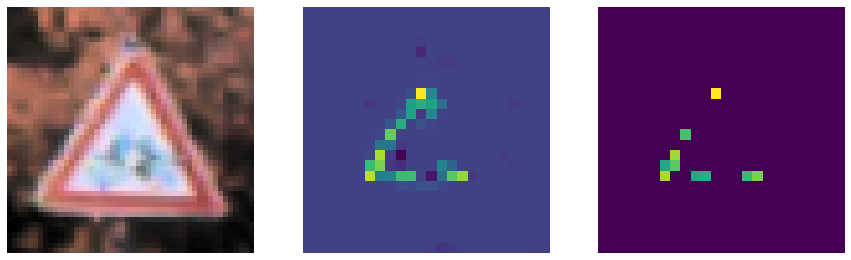

--------------------------------------------------
106
Predicted class by model and softplus:  18 18
Correct class:  18
Predicted class by model and softplus:  18 18
Correct class:  18


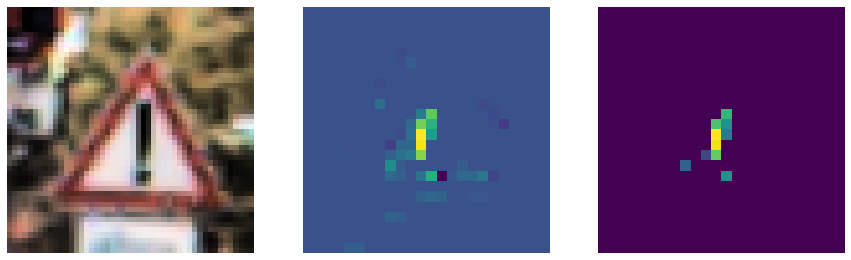

--------------------------------------------------
107
Predicted class by model and softplus:  1 1
Correct class:  1
Predicted class by model and softplus:  1 1
Correct class:  1


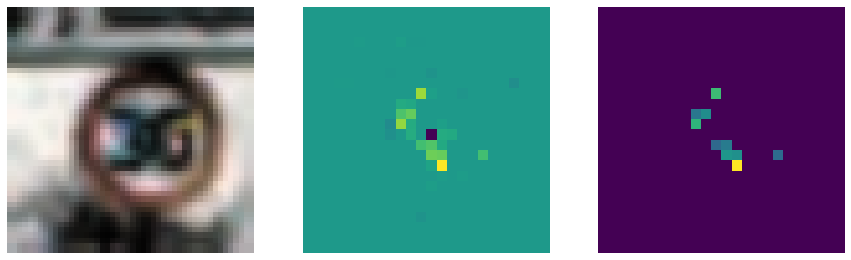

--------------------------------------------------
108
Predicted class by model and softplus:  12 12
Correct class:  12
Predicted class by model and softplus:  12 12
Correct class:  12


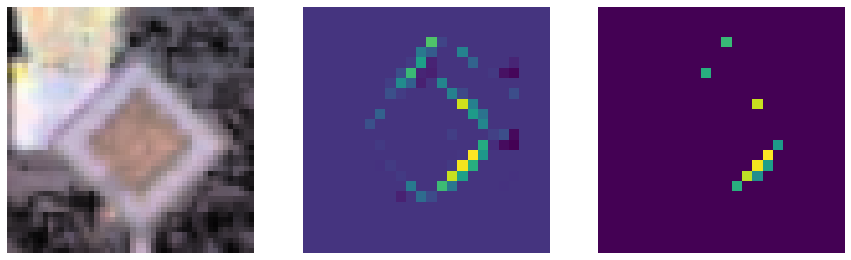

--------------------------------------------------
109
Predicted class by model and softplus:  34 34
Correct class:  40
Predicted class by model and softplus:  34 34
Correct class:  40


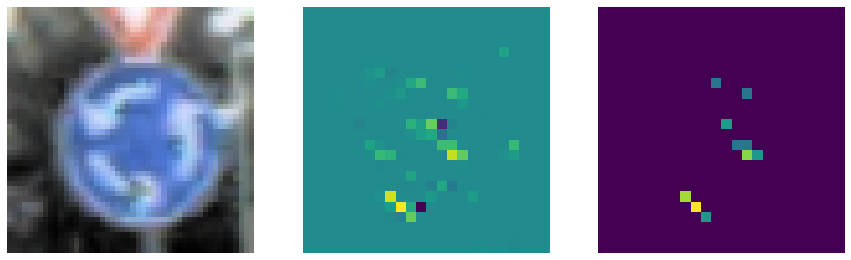

--------------------------------------------------
110
Predicted class by model and softplus:  2 2
Correct class:  2
Predicted class by model and softplus:  2 2
Correct class:  2


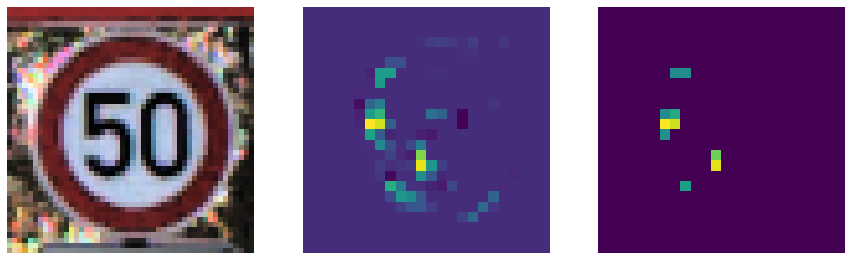

--------------------------------------------------
111
Predicted class by model and softplus:  25 25
Correct class:  25
Predicted class by model and softplus:  25 25
Correct class:  25


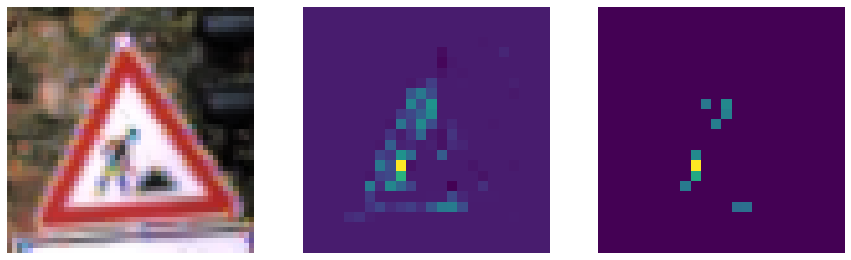

--------------------------------------------------
112
Predicted class by model and softplus:  8 8
Correct class:  8
Predicted class by model and softplus:  8 8
Correct class:  8


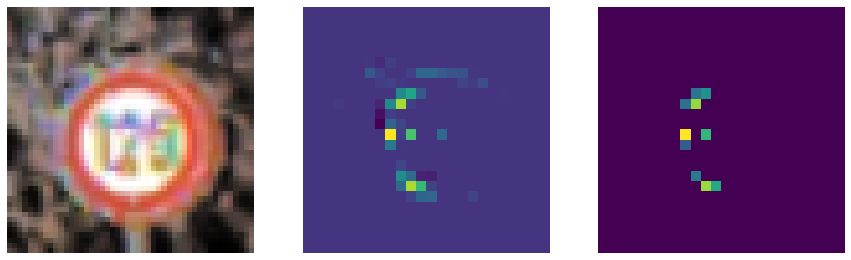

--------------------------------------------------
113
Predicted class by model and softplus:  14 14
Correct class:  14
Predicted class by model and softplus:  14 14
Correct class:  14


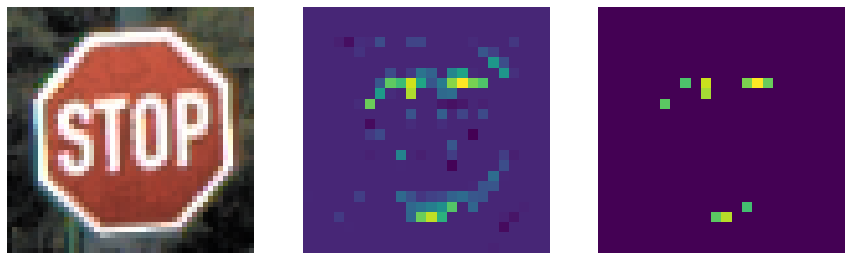

--------------------------------------------------
114
Predicted class by model and softplus:  21 21
Correct class:  21
Predicted class by model and softplus:  21 21
Correct class:  21


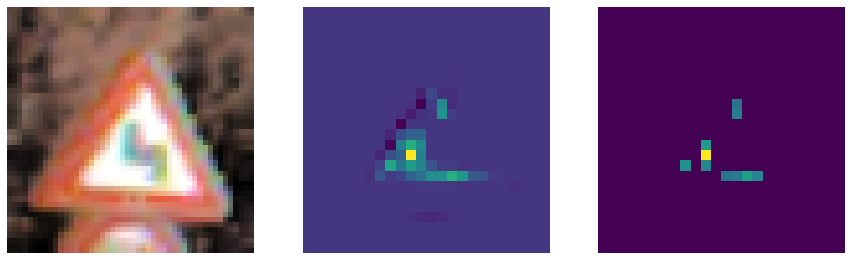

--------------------------------------------------
115
Predicted class by model and softplus:  2 2
Correct class:  2
Predicted class by model and softplus:  2 2
Correct class:  2


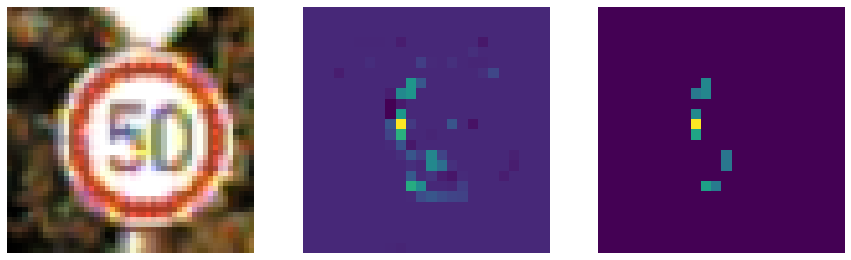

--------------------------------------------------
116
Predicted class by model and softplus:  35 35
Correct class:  35
Predicted class by model and softplus:  35 35
Correct class:  35


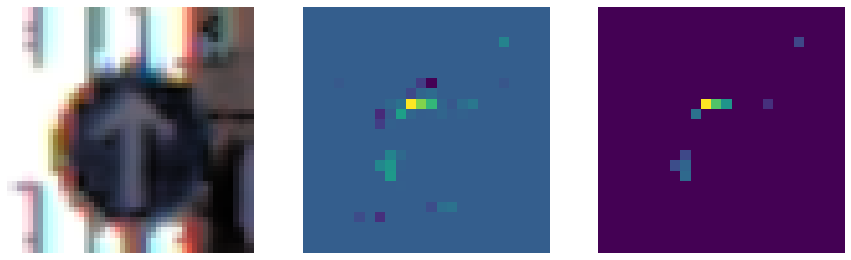

--------------------------------------------------
117
Predicted class by model and softplus:  8 8
Correct class:  8
Predicted class by model and softplus:  8 8
Correct class:  8


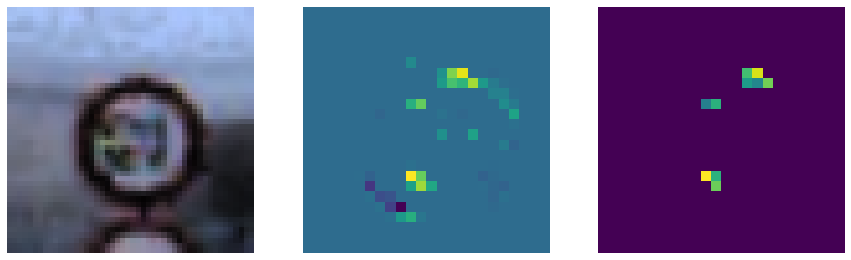

--------------------------------------------------
118
Predicted class by model and softplus:  37 37
Correct class:  37
Predicted class by model and softplus:  37 37
Correct class:  37


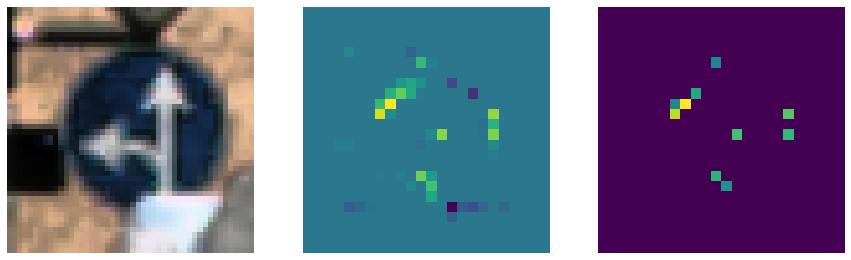

--------------------------------------------------
119
Predicted class by model and softplus:  12 12
Correct class:  12
Predicted class by model and softplus:  12 12
Correct class:  12


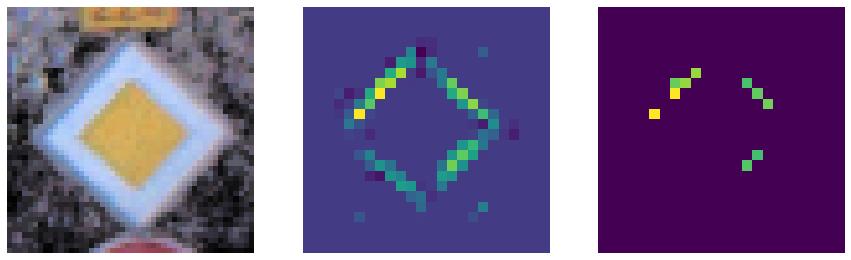

--------------------------------------------------
120
Predicted class by model and softplus:  40 40
Correct class:  40
Predicted class by model and softplus:  40 40
Correct class:  40


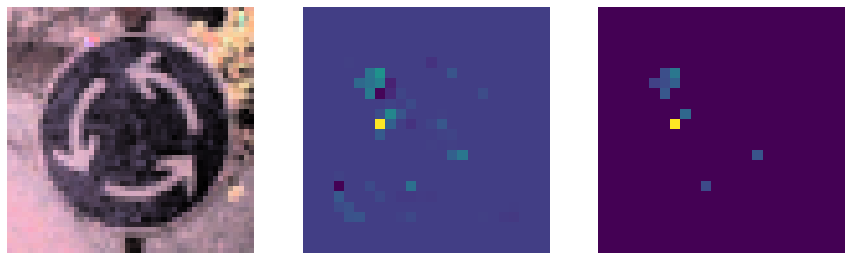

--------------------------------------------------
121
Predicted class by model and softplus:  1 1
Correct class:  1
Predicted class by model and softplus:  1 1
Correct class:  1


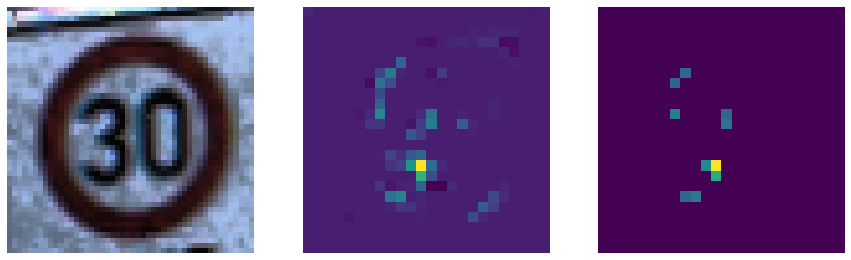

--------------------------------------------------
122
Predicted class by model and softplus:  31 31
Correct class:  31
Predicted class by model and softplus:  31 31
Correct class:  31


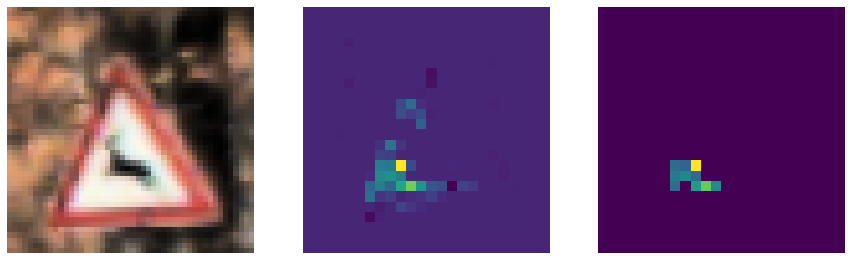

--------------------------------------------------
123
Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


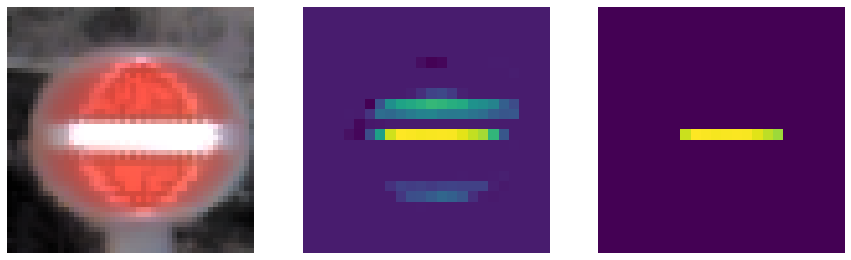

--------------------------------------------------
124
Predicted class by model and softplus:  3 3
Correct class:  3
Predicted class by model and softplus:  3 3
Correct class:  3


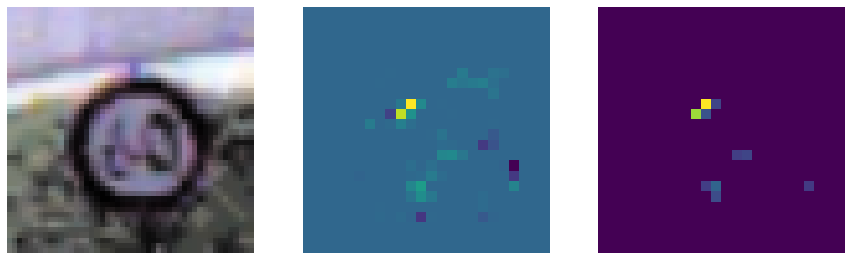

--------------------------------------------------
125
Predicted class by model and softplus:  2 2
Correct class:  2
Predicted class by model and softplus:  2 2
Correct class:  2


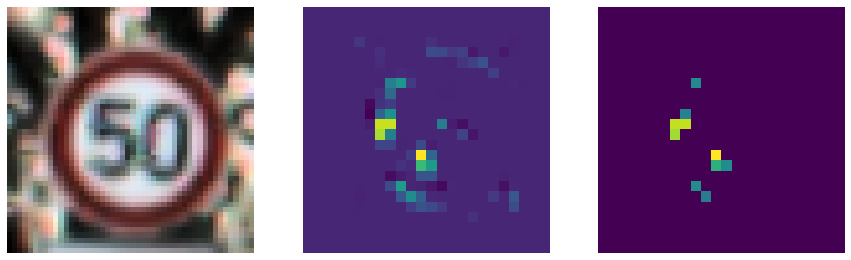

--------------------------------------------------
126
Predicted class by model and softplus:  12 12
Correct class:  12
Predicted class by model and softplus:  12 12
Correct class:  12


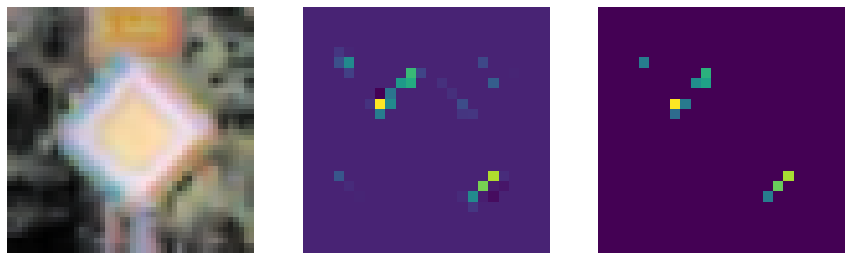

--------------------------------------------------
127
Predicted class by model and softplus:  12 12
Correct class:  12
Predicted class by model and softplus:  12 12
Correct class:  12


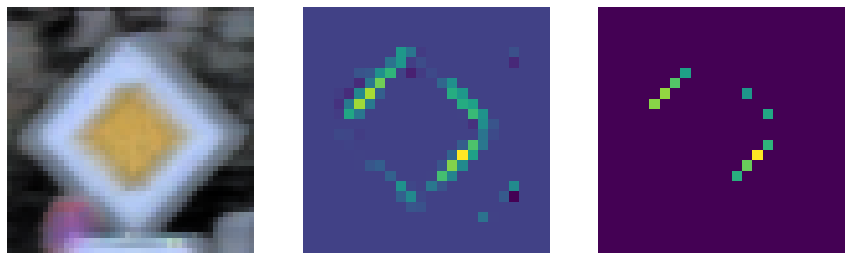

--------------------------------------------------
128
Predicted class by model and softplus:  18 18
Correct class:  18
Predicted class by model and softplus:  18 18
Correct class:  18


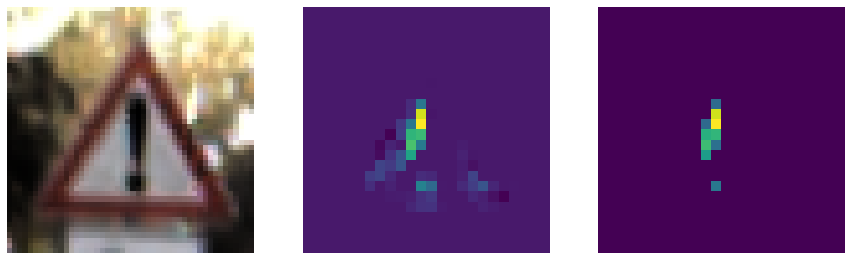

--------------------------------------------------
129
Predicted class by model and softplus:  31 31
Correct class:  31
Predicted class by model and softplus:  31 31
Correct class:  31


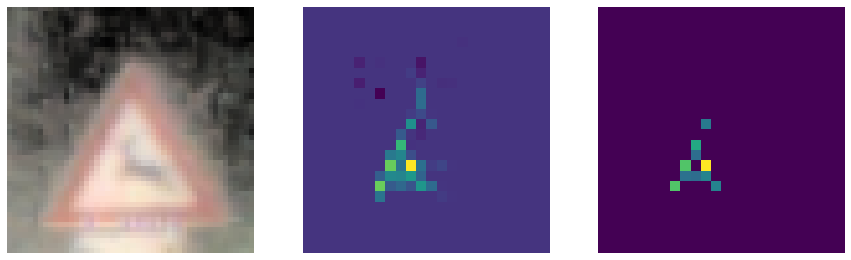

--------------------------------------------------
130
Predicted class by model and softplus:  31 31
Correct class:  31
Predicted class by model and softplus:  31 31
Correct class:  31


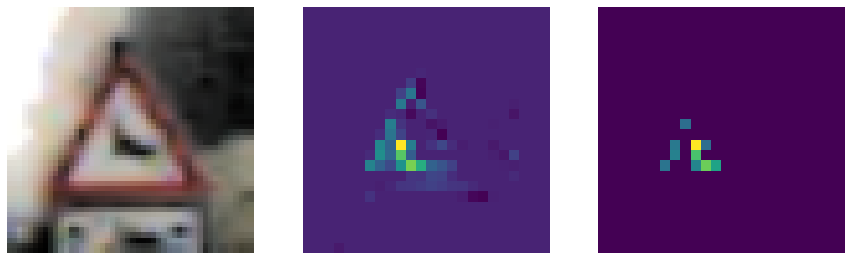

--------------------------------------------------
131
Predicted class by model and softplus:  10 10
Correct class:  10
Predicted class by model and softplus:  10 10
Correct class:  10


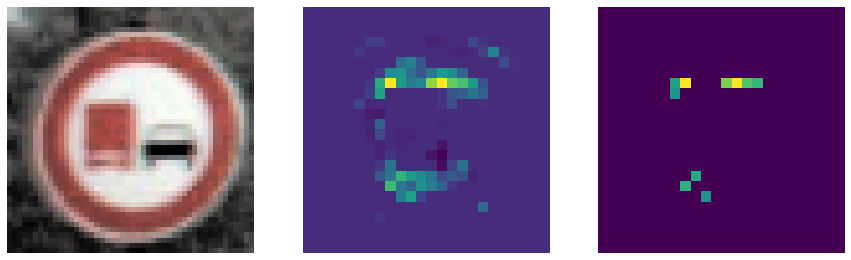

--------------------------------------------------
132
Predicted class by model and softplus:  4 4
Correct class:  4
Predicted class by model and softplus:  4 4
Correct class:  4


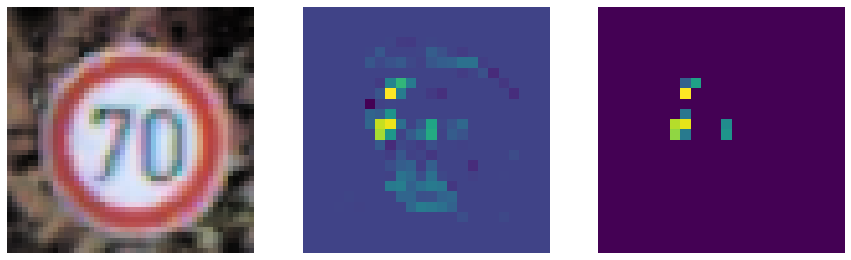

--------------------------------------------------
133
Predicted class by model and softplus:  1 1
Correct class:  1
Predicted class by model and softplus:  1 1
Correct class:  1


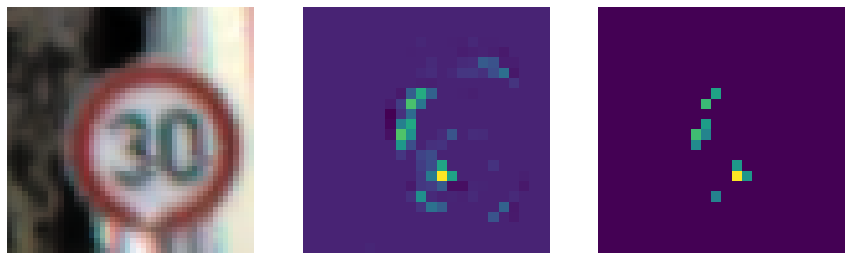

--------------------------------------------------
134
Predicted class by model and softplus:  14 14
Correct class:  14
Predicted class by model and softplus:  14 14
Correct class:  14


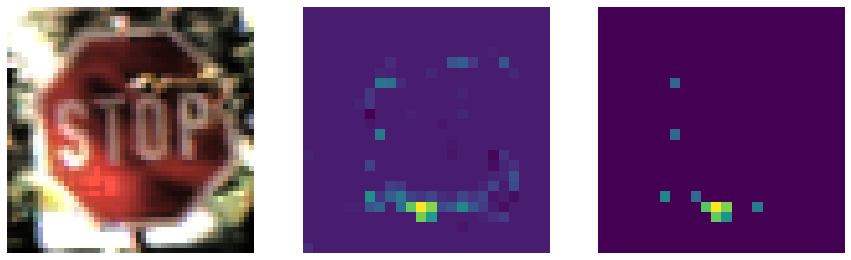

--------------------------------------------------
135
Predicted class by model and softplus:  1 1
Correct class:  1
Predicted class by model and softplus:  1 1
Correct class:  1


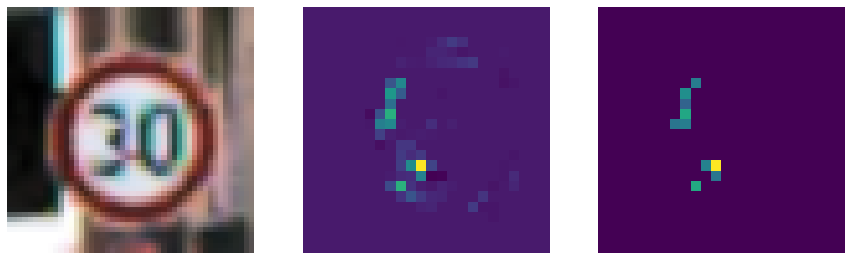

--------------------------------------------------
136
Predicted class by model and softplus:  13 13
Correct class:  13
Predicted class by model and softplus:  13 13
Correct class:  13


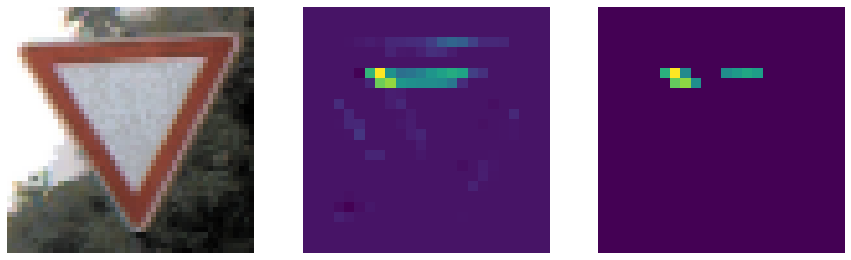

--------------------------------------------------
137
Predicted class by model and softplus:  18 18
Correct class:  18
Predicted class by model and softplus:  18 18
Correct class:  18


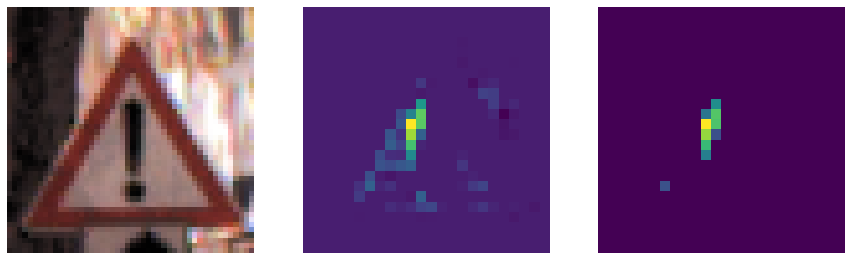

--------------------------------------------------
138
Predicted class by model and softplus:  1 1
Correct class:  1
Predicted class by model and softplus:  1 1
Correct class:  1


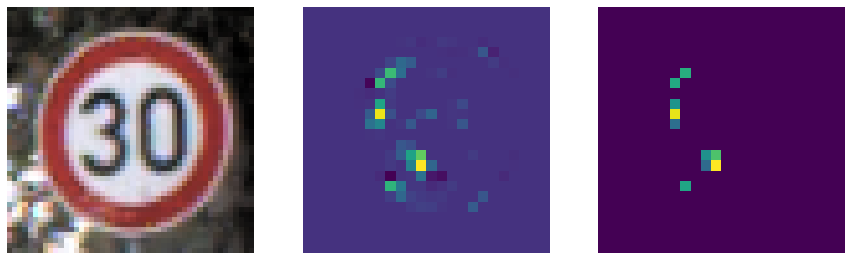

--------------------------------------------------
139
Predicted class by model and softplus:  5 5
Correct class:  5
Predicted class by model and softplus:  5 5
Correct class:  5


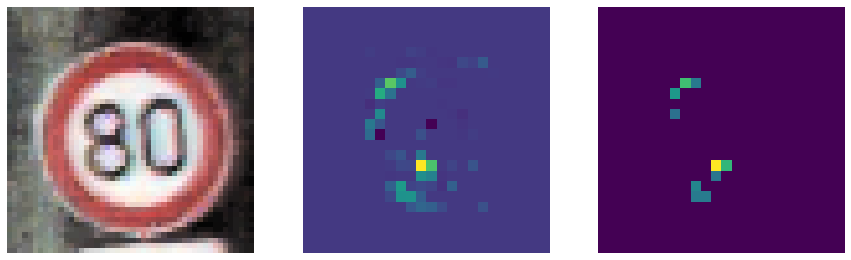

--------------------------------------------------
140
Predicted class by model and softplus:  4 4
Correct class:  4
Predicted class by model and softplus:  4 4
Correct class:  4


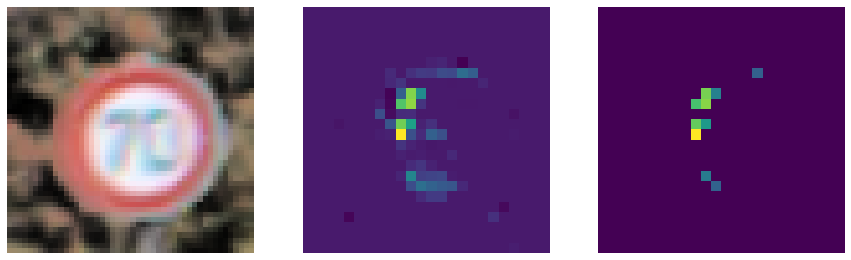

--------------------------------------------------
141
Predicted class by model and softplus:  38 38
Correct class:  38
Predicted class by model and softplus:  38 38
Correct class:  38


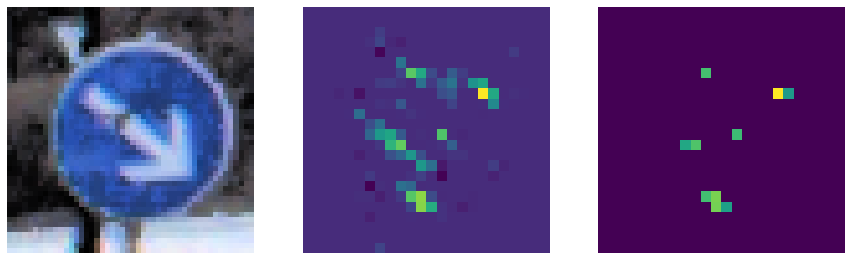

--------------------------------------------------
142
Predicted class by model and softplus:  2 2
Correct class:  2
Predicted class by model and softplus:  2 2
Correct class:  2


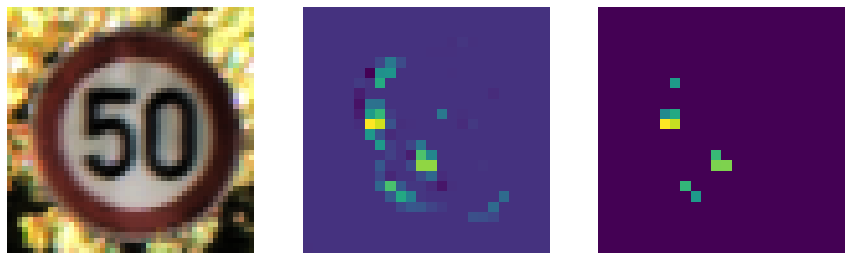

--------------------------------------------------
143
Predicted class by model and softplus:  13 13
Correct class:  13
Predicted class by model and softplus:  13 13
Correct class:  13


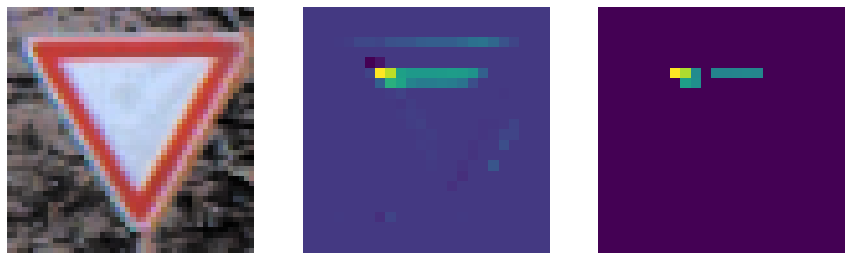

--------------------------------------------------
144
Predicted class by model and softplus:  13 13
Correct class:  13
Predicted class by model and softplus:  13 13
Correct class:  13


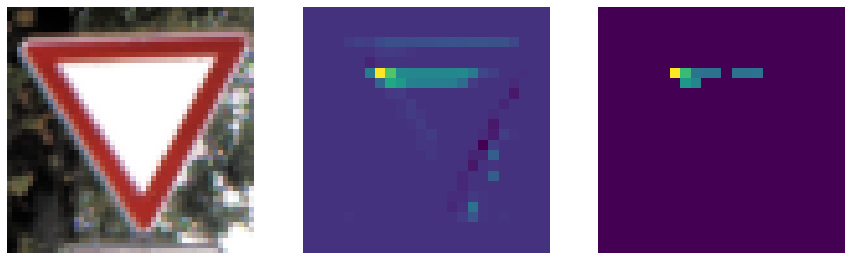

--------------------------------------------------
145
Predicted class by model and softplus:  12 12
Correct class:  12
Predicted class by model and softplus:  12 12
Correct class:  12


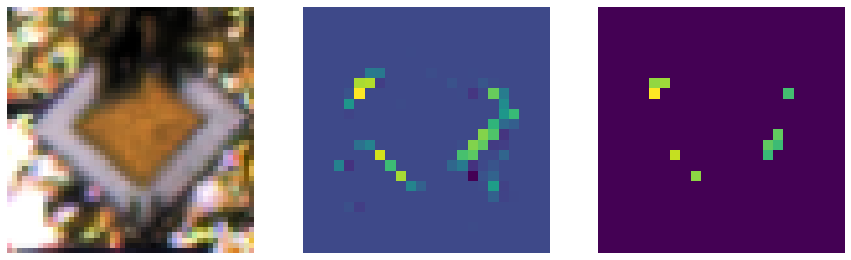

--------------------------------------------------
146
Predicted class by model and softplus:  38 38
Correct class:  38
Predicted class by model and softplus:  38 38
Correct class:  38


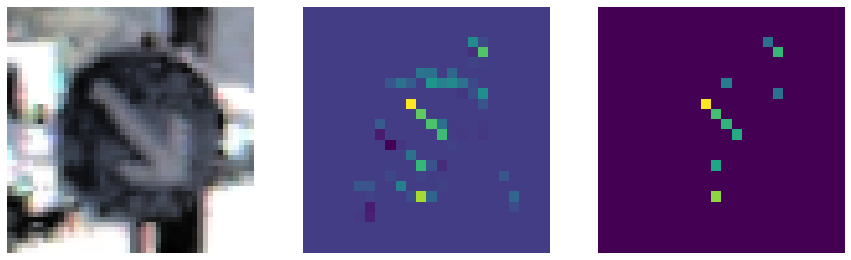

--------------------------------------------------
147
Predicted class by model and softplus:  4 4
Correct class:  4
Predicted class by model and softplus:  4 4
Correct class:  4


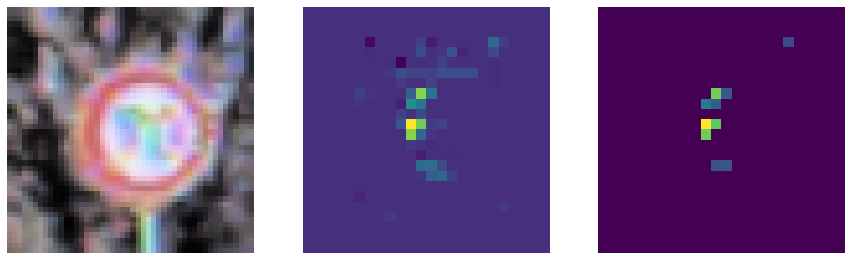

--------------------------------------------------
148
Predicted class by model and softplus:  13 13
Correct class:  13
Predicted class by model and softplus:  13 13
Correct class:  13


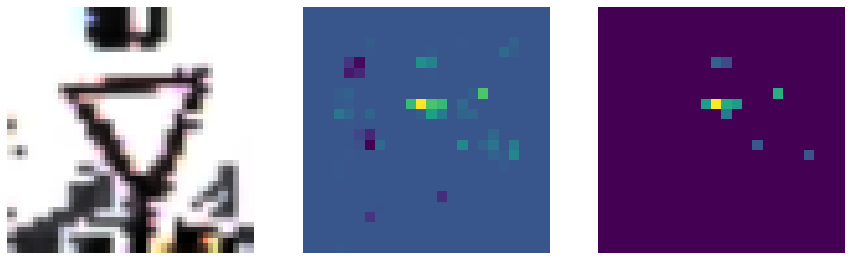

--------------------------------------------------
149
Predicted class by model and softplus:  11 11
Correct class:  11
Predicted class by model and softplus:  11 11
Correct class:  11


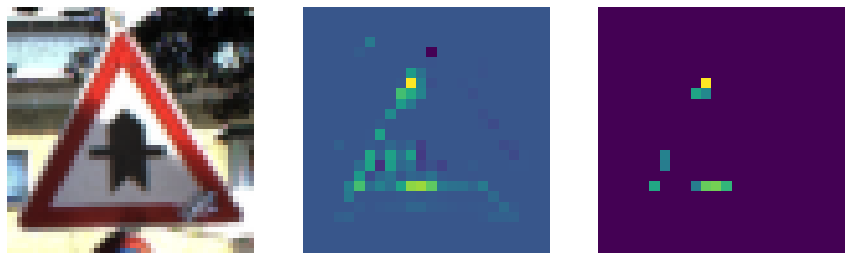

--------------------------------------------------
150
Predicted class by model and softplus:  10 10
Correct class:  10
Predicted class by model and softplus:  10 10
Correct class:  10


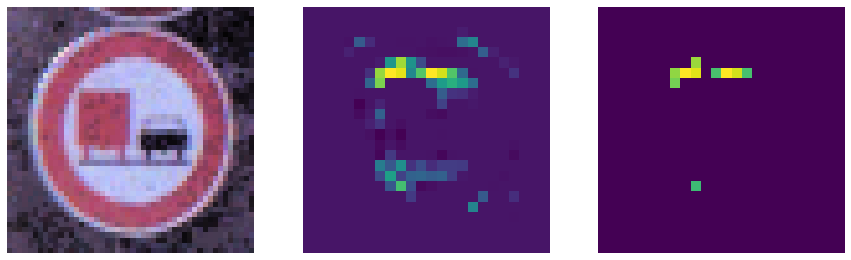

--------------------------------------------------
151
Predicted class by model and softplus:  33 33
Correct class:  33
Predicted class by model and softplus:  33 33
Correct class:  33


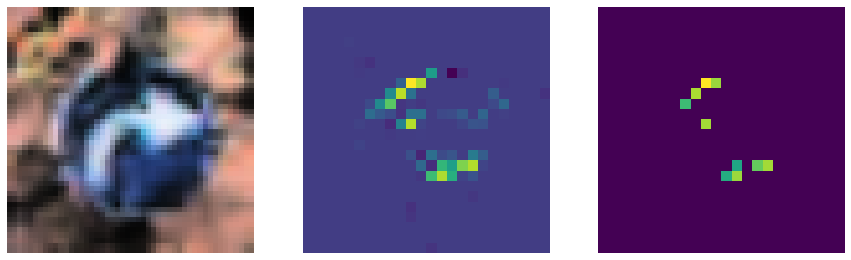

--------------------------------------------------
152
Predicted class by model and softplus:  1 1
Correct class:  1
Predicted class by model and softplus:  1 1
Correct class:  1


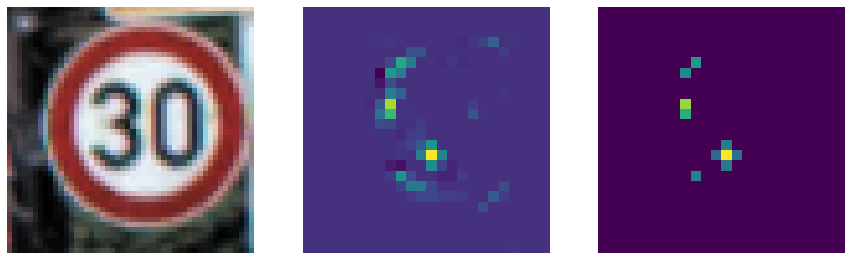

--------------------------------------------------
153


KeyboardInterrupt: ignored

In [9]:
for i in range(200):
# for i in [19, 29, 51, 82, 91, 124, 187]:
  k = 10
  print('-'*50)
  print(i)
  image = np.squeeze(X[i:i+1])
  correct_class = np.argmax(Y[i])
  show_map_row(image, image, correct_class, k)
# unperturbed | perturbed | 
# perturb by CNN-Cert bounds
# plot k vs bounds

Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


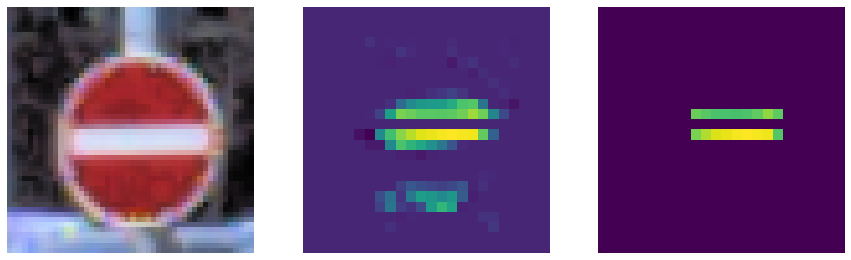

In [ ]:
i = 19

top_k = 18
x_0 = X[i:i+1] # 1 48 48 3
image = np.squeeze(x_0)
correct_class = np.argmax(Y[i])
show_map_row(image, image, correct_class, top_k)


In [ ]:
cam_map = get_cam(x_0[0], correct_class)
r_max, c_max = get_maximum_indices(cam_map, top_k)

def get_top_k_overlap(cam_map, cam_map_pert, top_k):
  r_max, c_max = get_maximum_indices(cam_map, top_k)
  r_max_pert, c_max_pert = get_maximum_indices(cam_map_pert, top_k)
  return len(np.intersect1d(10000 * r_max + c_max, 10000 * r_max_pert + c_max_pert))

def get_maximum_rank(cam_map, cam_map_pert, top_k):
  r_max_orig, c_max_orig = get_maximum_indices_sorted(cam_map, top_k)
  indices_orig = r_max_orig * cam_map.shape[0] + c_max_orig
  r_max_new, c_max_new = get_maximum_indices_sorted(cam_map_pert, cam_map_pert.shape[0] ** 2)
  indices_new = r_max_new * cam_map.shape[0] + c_max_new
  max_index = 0
  for i in indices_orig:
    max_index = max(max_index, 1 + list(indices_new).index(i))
  return max_index


Predicted class by model and softplus:  17 17
Correct class:  17


17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


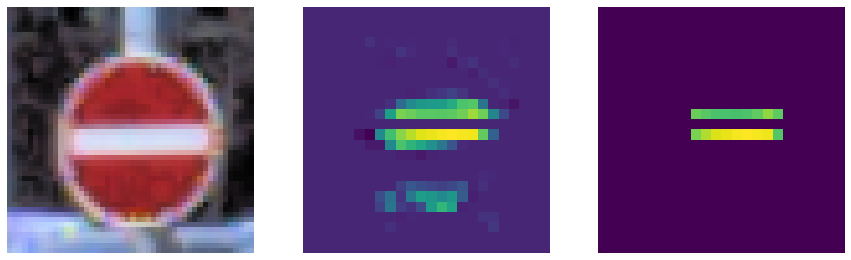

Pixels same:  18
Maximum rank:  18
----------
Perturbation size:  0.0050000027
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


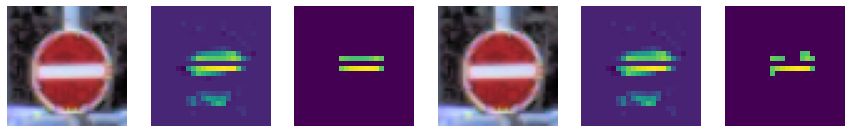

Pixels same:  15
Maximum rank:  21
----------
Perturbation size:  0.01000002
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


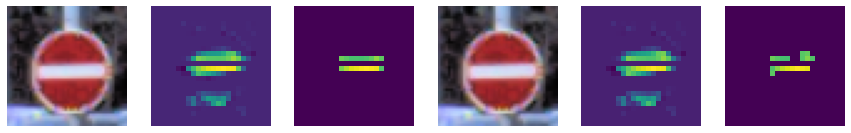

Pixels same:  15
Maximum rank:  21
----------
Perturbation size:  0.0150000155
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


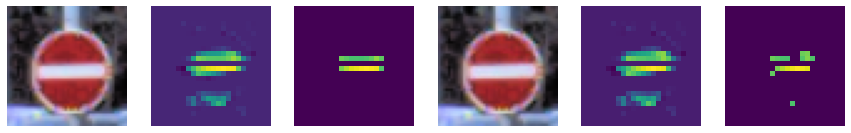

Pixels same:  14
Maximum rank:  23
----------
Perturbation size:  0.02000001
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


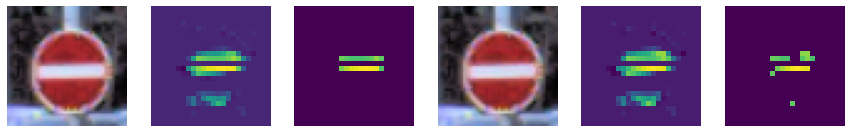

Pixels same:  14
Maximum rank:  24
----------
Perturbation size:  0.025000013
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


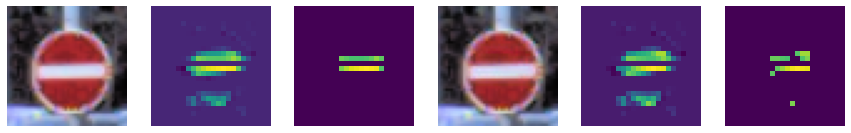

Pixels same:  13
Maximum rank:  30
----------
Perturbation size:  0.030000016
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


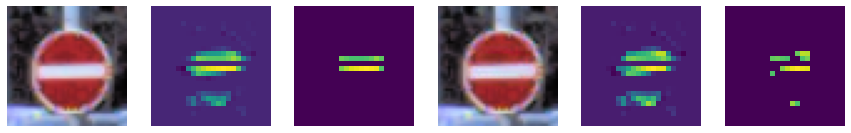

Pixels same:  12
Maximum rank:  34
----------
Perturbation size:  0.035000026
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted class by model and softplus:  17 17
Correct class:  17


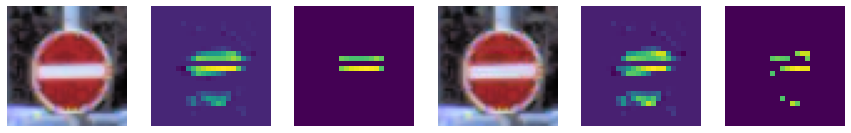

Pixels same:  11
Maximum rank:  36
----------
Perturbation size:  0.04000002
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


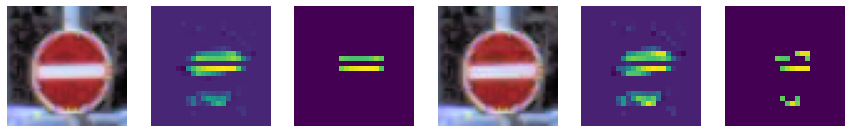

Pixels same:  10
Maximum rank:  40
----------
Perturbation size:  0.045000024
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted class by model and softplus:  17 17
Correct class:  17


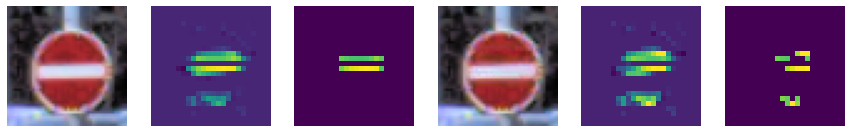

Pixels same:  9
Maximum rank:  43
----------
Perturbation size:  0.050000012
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted class by model and softplus:  17 17
Correct class:  17


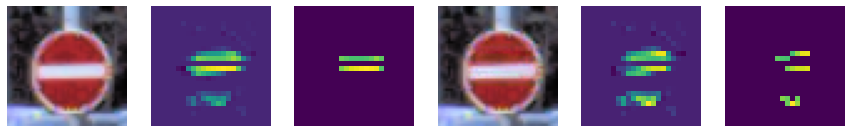

Pixels same:  8
Maximum rank:  50
----------
Perturbation size:  0.055000015
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


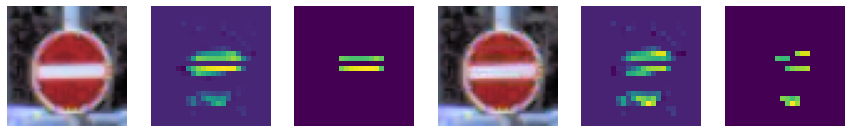

Pixels same:  8
Maximum rank:  56
----------
Perturbation size:  0.060000017
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


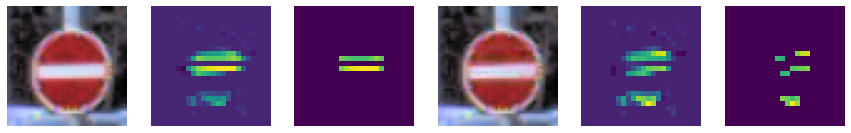

Pixels same:  6
Maximum rank:  77
----------
Perturbation size:  0.06500002
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted class by model and softplus:  17 17
Correct class:  17


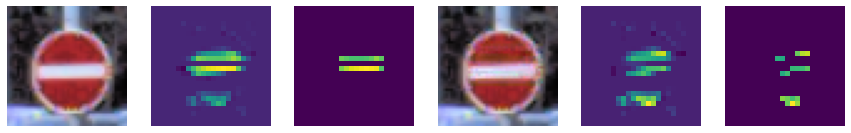

Pixels same:  6
Maximum rank:  100
----------
Perturbation size:  0.07000002
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted class by model and softplus:  17 17
Correct class:  17


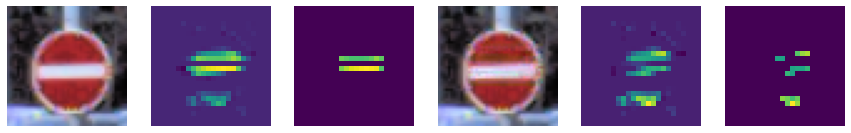

Pixels same:  6
Maximum rank:  108
----------
Perturbation size:  0.075000025
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


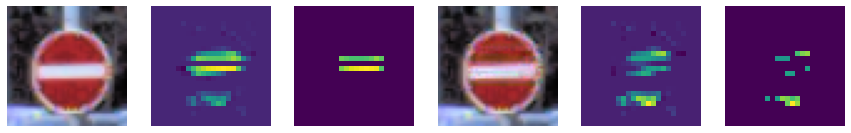

Pixels same:  4
Maximum rank:  111
----------
Perturbation size:  0.08000003
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


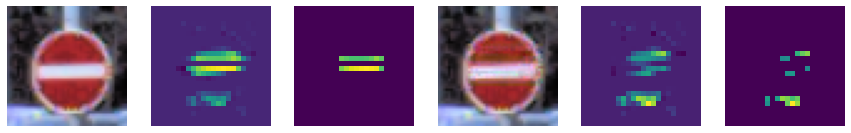

Pixels same:  3
Maximum rank:  115
----------
Perturbation size:  0.08500002
17 17 17
Predicted class by model and softplus:  17 17
Correct class:  17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted class by model and softplus:  17 17
Correct class:  17


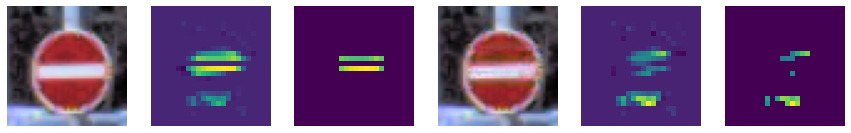

Pixels same:  3
Maximum rank:  456
----------
Perturbation size:  0.09000002
17 14 17
Predicted class by model and softplus:  17 17
Correct class:  17
Predicted class by model and softplus:  17 17
Correct class:  17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


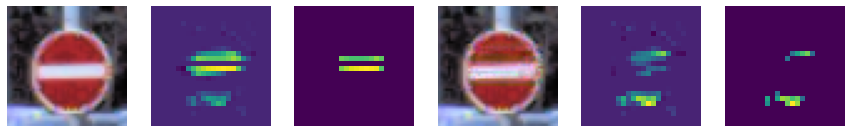

Pixels same:  1
Maximum rank:  481
----------
Perturbation size:  0.09500001
17 14 17
Predicted class by model and softplus:  17 17
Correct class:  17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted class by model and softplus:  17 17
Correct class:  17


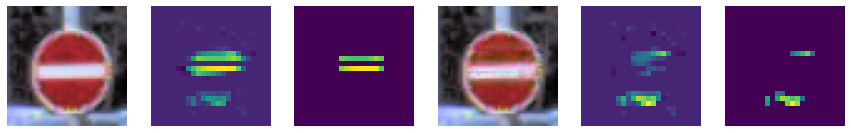

Pixels same:  0
Maximum rank:  481
----------
Perturbation size:  0.1


In [ ]:

def res(inp, correct_class):
  cam_map_gd = tf.zeros([24, 24], dtype=tf.dtypes.float32)
  last_conv_layer_output = last_conv_layer_output_model(inp)
  for channel in range(channels):
    cam_map_gd += last_conv_layer_output[0, :, :, channel] * fc_weights[channel, correct_class]
  result = 0
  for i in range(top_k):
    result -= cam_map_gd[r_max[i]][c_max[i]]
  return cam_map_gd, result

inp = tf.Variable(x_0, dtype=tf.float32)
epsilon = 0.1
for i in range(20):
  with tf.GradientTape(persistent=True) as tape:
    cam_map_gd, result = res(inp, correct_class)
  if i == 0:
    cam_orig = top_k_cam_map(cam_map_gd.numpy(), top_k) 

  # show_image(inp.numpy())
  print(np.argmax(model.predict(inp.numpy())), np.argmax(model_sp.predict(inp.numpy())), correct_class)
  if np.argmax(model.predict(inp.numpy())) == correct_class:
    # show_image(inp.numpy().squeeze())
    # correct_cam = get_cam(inp.numpy().squeeze(), correct_class)
    # print(np.linalg.norm(correct_cam - cam_map.numpy()))
    # show_cam_map(cam_map.numpy(), True)
    # show_image(top_k_cam_map(cam_map.numpy(), 5))
    # show_cam_overlay(x_0[0], cam_map.numpy())
    top_k_map = top_k_cam_map(cam_map_gd.numpy(), top_k)
    # for j in range(top_k):
      # print(r_max[j], c_max[j], top_k_map[r_max[j], c_max[j]])
    show_map_row(image, inp.numpy().squeeze(), correct_class, top_k)
    print("Pixels same: ", get_top_k_overlap(cam_map, cam_map_gd.numpy(), top_k))
    print("Maximum rank: ", get_maximum_rank(cam_map, cam_map_gd.numpy(), top_k))

  grads = tape.gradient(result, [inp])
  candidate_inp = inp + 0.005 * tf.math.sign(grads[0]).numpy()
  pert = np.clip(candidate_inp - x_0, -epsilon, epsilon)
  print('-' * 10)
  print("Perturbation size: ", np.max(np.abs(pert)))

  inp.assign(x_0 + pert)